## packages

In [1]:
from datetime import datetime
from datetime import timedelta
import pandas as pd
import numpy as np
import datetime
import matplotlib.pyplot as plt
from matplotlib.pyplot import subplots
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor as VIF
from statsmodels.stats.anova import anova_lm
import warnings
from dateutil.relativedelta import relativedelta
from dateutil import parser
from sklearn.linear_model import LinearRegression

warnings.filterwarnings("ignore")

## data prep

In [2]:
# Function call to process the tradewed data file
def data_preprocess(filepath):
    rawdata = pd.read_csv(filepath)
    rawdata = rawdata.loc[rawdata['ACCEPTEDVOL'] != 0] # Ignore trade stamps with zero volume
    # Remove BILLs , STRIPs and TRSY FRN data to skip the computation from yield to price for Bills and negative spreads for Strips + Treasury FRN
    substring = 'Bill'
    substring2 = 'Strip'
    substring3 = 'TRSY FRN'
    filter = rawdata['MATURITY_RANGE'].str.contains(substring)
    rawdata = rawdata[~filter]
    filter2 = rawdata['MATURITY_RANGE'].str.contains(substring2)
    rawdata = rawdata[~filter2]
    filter3 = rawdata['MATURITY_RANGE'].str.contains(substring3)
    rawdata = rawdata[~filter3]
    rawdata = rawdata.loc[rawdata['TRADETYPE'] == 'OUTRIGHT'] # Only consider outright trades
    rawdata.reset_index(inplace=True)
    # Convert TRADETIME , MATURITY DATE and TRADE DATE to datetime and assign new index
    tradetime = []
    tradedate = []
    maturitydate = []
    for i in range(rawdata.shape[0]):
        tradetime.append(datetime.datetime.strptime(rawdata['TRADETIME'].iloc[i].rstrip(' Z'), "%Y-%m-%d %H:%M:%S.%f"))
        tradedate.append(datetime.datetime.strptime(rawdata['TRADEDATE'].iloc[i], '%m/%d/%y'))
        maturitydate.append(datetime.datetime.strptime(rawdata['MATURITY_DATE'].iloc[i], '%m/%d/%y'))
    rawdata['TIMESTAMP'] = tradetime
    rawdata['TRADEDATE'] = tradedate
    rawdata['MATURITY_DATE'] = maturitydate
    rawdata.set_index('TIMESTAMP', inplace= True)
    rawdata.sort_index(inplace=True)
    return rawdata

In [3]:
tw1 = data_preprocess('Blockhouse Data 1.csv')
tw2 = data_preprocess('Blockhouse Data 2.csv')
tw3 = data_preprocess('Blockhouse Data 3.csv')
tw4 = data_preprocess('Blockhouse Data 4.csv')
rawdata = pd.concat([tw1, tw2, tw3, tw4], axis =0)

In [4]:
rawdata.columns

Index(['index', 'TRADEDATE', 'DEALER', 'DEALERCOUNT', 'ACCEPTED',
       'SEEN_INQUIRY', 'ACCEPTEDVOL', 'SEENVOLUME', 'PRICE', 'TRADETIME',
       'INSTRUMENT', 'INSTRUMENT_DESC', 'MATURITY_DATE', 'MATURITY_RANGE',
       'COUPON_RATE', 'SIDE', 'COMP_ASK', 'COMP_BID', 'PROTOCOL', 'TRADETYPE',
       'SOURCE'],
      dtype='object')

In [5]:
rawdata.head(5)

,index,TRADEDATE,DEALER,DEALERCOUNT,ACCEPTED,SEEN_INQUIRY,ACCEPTEDVOL,SEENVOLUME,PRICE,TRADETIME,...,INSTRUMENT_DESC,MATURITY_DATE,MATURITY_RANGE,COUPON_RATE,SIDE,COMP_ASK,COMP_BID,PROTOCOL,TRADETYPE,SOURCE
TIMESTAMP,,,,,,,,,,,,,,,,,,,,,
2023-10-02 06:47:43,47059,2023-10-02,D69,5,1,1,1100.90,1100.90,99.761887,2023-10-02 06:47:43.000 Z,...,"T 4 5/8 <MD2Y,2462045> 5yr",2028-09-30,Note 3.5 - 5.5 Year,4.625,BUY,99.769531,99.753906,REG List,OUTRIGHT,TW
2023-10-02 06:47:43,19829,2023-10-02,D38,5,1,1,3939.00,3939.00,99.691574,2023-10-02 06:47:43.000 Z,...,"T 5 <MD2Y,2460919>",2025-08-31,Note 1.5 - 3.5 Year,5.000,BUY,99.703125,99.691406,REG List,OUTRIGHT,TW
2023-10-02 06:47:43,50786,2023-10-02,D28,5,1,1,297.95,297.95,89.461106,2023-10-02 06:47:43.000 Z,...,"T 1 1/8 <MD2Y,2461345>",2026-10-31,Note 1.5 - 3.5 Year,1.125,BUY,89.488281,89.433594,REG List,OUTRIGHT,TW
2023-10-02 06:47:43,24582,2023-10-02,D38,5,1,1,676.70,676.70,90.133013,2023-10-02 06:47:43.000 Z,...,"T 4 1/8 <MD2Y,2471130> 30yr",2053-08-15,Note >10 Year,4.125,BUY,90.160156,90.128906,REG List,OUTRIGHT,TW
2023-10-02 06:47:43,57986,2023-10-02,D11,5,1,1,176.75,176.75,60.906450,2023-10-02 06:47:43.000 Z,...,"T 2 1/4 <MD2Y,2470583>",2052-02-15,Note >10 Year,2.250,BUY,60.960938,60.882812,REG List,OUTRIGHT,TW


In [6]:
filtered_rawdata = rawdata[['DEALER', 'ACCEPTEDVOL', 'PRICE', 'INSTRUMENT', 'MATURITY_RANGE','MATURITY_DATE', 'TRADEDATE',"COUPON_RATE",'SIDE','COMP_ASK','COMP_BID']].copy()
filtered_rawdata.head()

,DEALER,ACCEPTEDVOL,PRICE,INSTRUMENT,MATURITY_RANGE,MATURITY_DATE,TRADEDATE,COUPON_RATE,SIDE,COMP_ASK,COMP_BID
TIMESTAMP,,,,,,,,,,,
2023-10-02 06:47:43,D69,1100.90,99.761887,91282CJA0,Note 3.5 - 5.5 Year,2028-09-30,2023-10-02,4.625,BUY,99.769531,99.753906
2023-10-02 06:47:43,D38,3939.00,99.691574,91282CHV6,Note 1.5 - 3.5 Year,2025-08-31,2023-10-02,5.000,BUY,99.703125,99.691406
2023-10-02 06:47:43,D28,297.95,89.461106,91282CDG3,Note 1.5 - 3.5 Year,2026-10-31,2023-10-02,1.125,BUY,89.488281,89.433594
2023-10-02 06:47:43,D38,676.70,90.133013,912810TT5,Note >10 Year,2053-08-15,2023-10-02,4.125,BUY,90.160156,90.128906
2023-10-02 06:47:43,D11,176.75,60.906450,912810TD0,Note >10 Year,2052-02-15,2023-10-02,2.250,BUY,60.960938,60.882812


In [7]:
filtered_rawdata.shape

(50741, 11)

In [8]:
filtered_rawdata['SIGN'] = filtered_rawdata['SIDE'].apply(lambda x: 1 if x == 'BUY' else -1)
filtered_rawdata['ACCEPTEDVOL'] = filtered_rawdata['ACCEPTEDVOL'] * 10
filtered_rawdata['SIGNED_VOLUME'] = filtered_rawdata['ACCEPTEDVOL'] * filtered_rawdata['SIGN']
filtered_rawdata

,DEALER,ACCEPTEDVOL,PRICE,INSTRUMENT,MATURITY_RANGE,MATURITY_DATE,TRADEDATE,COUPON_RATE,SIDE,COMP_ASK,COMP_BID,SIGN,SIGNED_VOLUME
TIMESTAMP,,,,,,,,,,,,,
2023-10-02 06:47:43,D69,11009.0,99.761887,91282CJA0,Note 3.5 - 5.5 Year,2028-09-30,2023-10-02,4.625,BUY,99.769531,99.753906,1,11009.0
2023-10-02 06:47:43,D38,39390.0,99.691574,91282CHV6,Note 1.5 - 3.5 Year,2025-08-31,2023-10-02,5.000,BUY,99.703125,99.691406,1,39390.0
2023-10-02 06:47:43,D28,2979.5,89.461106,91282CDG3,Note 1.5 - 3.5 Year,2026-10-31,2023-10-02,1.125,BUY,89.488281,89.433594,1,2979.5
2023-10-02 06:47:43,D38,6767.0,90.133013,912810TT5,Note >10 Year,2053-08-15,2023-10-02,4.125,BUY,90.160156,90.128906,1,6767.0
2023-10-02 06:47:43,D11,1767.5,60.906450,912810TD0,Note >10 Year,2052-02-15,2023-10-02,2.250,BUY,60.960938,60.882812,1,1767.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-12-29 13:51:46,D50,202000.0,97.605301,9128283J7,Note 0 - 1.5 Year,2024-11-30,2023-12-29,2.125,SELL,97.640625,97.585938,-1,-202000.0
2023-12-29 13:51:46,D50,121200.0,95.769699,9128284V9,Note 3.5 - 5.5 Year,2028-08-15,2023-12-29,2.875,BUY,95.820312,95.726562,1,121200.0
2023-12-29 13:51:46,D28,252500.0,97.574051,9128283P3,Note 0 - 1.5 Year,2024-12-31,2023-12-29,2.250,SELL,97.605469,97.542969,-1,-252500.0


In [9]:
# Calculate years to maturity
ytm = []
for i in range(0,rawdata.shape[0]):
    ytm.append(relativedelta(filtered_rawdata['MATURITY_DATE'].iloc[i],filtered_rawdata['TRADEDATE'].iloc[i]).years)
filtered_rawdata['Years to Maturity'] = ytm
# calculate spreads
filtered_rawdata['Spread'] = (filtered_rawdata['COMP_ASK'] - filtered_rawdata['COMP_BID'])/2

In [10]:
filtered_rawdata['MATURITY_RANGE'].unique()

array(['Note 3.5 - 5.5 Year', 'Note 1.5 - 3.5 Year', 'Note >10 Year',
       'Note 5.5 - 10 Year', 'Note 0 - 1.5 Year', 'TIPS 0 - 5 year',
       'TIPS 5 - 10 year', 'TIPS > 10 year'], dtype=object)

In [11]:
filtered_rawdata

,DEALER,ACCEPTEDVOL,PRICE,INSTRUMENT,MATURITY_RANGE,MATURITY_DATE,TRADEDATE,COUPON_RATE,SIDE,COMP_ASK,COMP_BID,SIGN,SIGNED_VOLUME,Years to Maturity,Spread
TIMESTAMP,,,,,,,,,,,,,,,
2023-10-02 06:47:43,D69,11009.0,99.761887,91282CJA0,Note 3.5 - 5.5 Year,2028-09-30,2023-10-02,4.625,BUY,99.769531,99.753906,1,11009.0,4,0.007812
2023-10-02 06:47:43,D38,39390.0,99.691574,91282CHV6,Note 1.5 - 3.5 Year,2025-08-31,2023-10-02,5.000,BUY,99.703125,99.691406,1,39390.0,1,0.005859
2023-10-02 06:47:43,D28,2979.5,89.461106,91282CDG3,Note 1.5 - 3.5 Year,2026-10-31,2023-10-02,1.125,BUY,89.488281,89.433594,1,2979.5,3,0.027344
2023-10-02 06:47:43,D38,6767.0,90.133013,912810TT5,Note >10 Year,2053-08-15,2023-10-02,4.125,BUY,90.160156,90.128906,1,6767.0,29,0.015625
2023-10-02 06:47:43,D11,1767.5,60.906450,912810TD0,Note >10 Year,2052-02-15,2023-10-02,2.250,BUY,60.960938,60.882812,1,1767.5,28,0.039062
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-12-29 13:51:46,D50,202000.0,97.605301,9128283J7,Note 0 - 1.5 Year,2024-11-30,2023-12-29,2.125,SELL,97.640625,97.585938,-1,-202000.0,0,0.027344
2023-12-29 13:51:46,D50,121200.0,95.769699,9128284V9,Note 3.5 - 5.5 Year,2028-08-15,2023-12-29,2.875,BUY,95.820312,95.726562,1,121200.0,4,0.046875
2023-12-29 13:51:46,D28,252500.0,97.574051,9128283P3,Note 0 - 1.5 Year,2024-12-31,2023-12-29,2.250,SELL,97.605469,97.542969,-1,-252500.0,1,0.031250


## Parameter for Price Impact Model: daily_vol, adv, beta, lambda

In [12]:
filtered_rawdata.MATURITY_RANGE.value_counts()

MATURITY_RANGE
Note 1.5 - 3.5 Year    12244
Note 0 - 1.5 Year       9955
Note >10 Year           8946
Note 5.5 - 10 Year      8760
Note 3.5 - 5.5 Year     7661
TIPS 0 - 5 year         1620
TIPS > 10 year           782
TIPS 5 - 10 year         773
Name: count, dtype: int64

In [13]:
# List of maturity ranges to filter
note_maturity_ranges = ['Note 1.5 - 3.5 Year', 'Note 0 - 1.5 Year', 'Note >10 Year',
                        'Note 5.5 - 10 Year', 'Note 3.5 - 5.5 Year']

# Filter data for the specified maturity ranges
group1 = filtered_rawdata[filtered_rawdata['MATURITY_RANGE'].isin(note_maturity_ranges)]

### daily volatility

In [14]:
group1['TRADEDATE'] = pd.to_datetime(group1['TRADEDATE'])

# Group by 'TRADEDATE' and calculate the daily volatility as the standard deviation of 'PRICE'
daily_volatility = group1.groupby('TRADEDATE')['PRICE'].std()

# Map the daily volatility back to the original DataFrame
group1['Daily_Volatility'] = group1['TRADEDATE'].map(daily_volatility)

In [15]:
group1.head(3)

,DEALER,ACCEPTEDVOL,PRICE,INSTRUMENT,MATURITY_RANGE,MATURITY_DATE,TRADEDATE,COUPON_RATE,SIDE,COMP_ASK,COMP_BID,SIGN,SIGNED_VOLUME,Years to Maturity,Spread,Daily_Volatility
TIMESTAMP,,,,,,,,,,,,,,,,
2023-10-02 06:47:43,D69,11009.0,99.761887,91282CJA0,Note 3.5 - 5.5 Year,2028-09-30,2023-10-02,4.625,BUY,99.769531,99.753906,1,11009.0,4,0.007812,12.553247
2023-10-02 06:47:43,D38,39390.0,99.691574,91282CHV6,Note 1.5 - 3.5 Year,2025-08-31,2023-10-02,5.000,BUY,99.703125,99.691406,1,39390.0,1,0.005859,12.553247
2023-10-02 06:47:43,D28,2979.5,89.461106,91282CDG3,Note 1.5 - 3.5 Year,2026-10-31,2023-10-02,1.125,BUY,89.488281,89.433594,1,2979.5,3,0.027344,12.553247


In [16]:
group1.Daily_Volatility

TIMESTAMP
2023-10-02 06:47:43    12.553247
2023-10-02 06:47:43    12.553247
2023-10-02 06:47:43    12.553247
2023-10-02 06:47:43    12.553247
2023-10-02 06:47:43    12.553247
                         ...    
2023-12-29 13:51:46     9.042891
2023-12-29 13:51:46     9.042891
2023-12-29 13:51:46     9.042891
2023-12-29 13:51:46     9.042891
2023-12-29 13:51:46     9.042891
Name: Daily_Volatility, Length: 47566, dtype: float64

### ADV: average daily volume

In [17]:
def calculate_monthly_adv(data):
    # resample volume to daily
    daily_vol = data['ACCEPTEDVOL'].resample('D').sum()
    print("Daily Total Volume:\n", daily_vol.head(10))

    october_total_vol = daily_vol[0]  # total volume for October
    december_total_vol = daily_vol[2]  # total volume for December
    # Calculate the number of trading days for October and December
    october_trading_days = data['ACCEPTEDVOL']['2023-10'].count()
    december_trading_days = data['ACCEPTEDVOL']['2023-12'].count()

    # Calculate ADV
    october_adv = october_total_vol / october_trading_days
    december_adv = december_total_vol / december_trading_days

    # Assign the ADV value
    data.loc['2023-10', 'ADV'] = october_adv
    data.loc['2023-12', 'ADV'] = december_adv

    # Forward fill for consistency
    data['ADV'].fillna(method='ffill', inplace=True)
    data['ADV'].fillna(method='bfill', inplace=True)

    return data[['ADV']], october_total_vol, december_total_vol

In [18]:
group1[['ADV']], october_total_vol, december_total_vol = calculate_monthly_adv(group1)

Daily Total Volume:
 TIMESTAMP
2023-10-02    14129669.72
2023-10-03    12331141.51
2023-10-04    10819414.92
2023-10-05     8190788.92
2023-10-06     6369606.41
2023-10-07           0.00
2023-10-08           0.00
2023-10-09           0.00
2023-10-10    13034806.49
2023-10-11    11529757.01
Freq: D, Name: ACCEPTEDVOL, dtype: float64


In [19]:
group1.ADV

TIMESTAMP
2023-10-02 06:47:43    602.570247
2023-10-02 06:47:43    602.570247
2023-10-02 06:47:43    602.570247
2023-10-02 06:47:43    602.570247
2023-10-02 06:47:43    602.570247
                          ...    
2023-12-29 13:51:46    448.621923
2023-12-29 13:51:46    448.621923
2023-12-29 13:51:46    448.621923
2023-12-29 13:51:46    448.621923
2023-12-29 13:51:46    448.621923
Name: ADV, Length: 47566, dtype: float64

In [20]:
print('OCT',october_total_vol)
print('DEC',december_total_vol)

OCT 14129669.72
DEC 10819414.92


### beta

In [21]:
import math
beta = math.log(2)/1 # half-life is 30min, bin is 60 min
print('beta:',beta)

beta: 0.6931471805599453


### qt: quanity/volume in each bin (set bin 60min here)

In [22]:
def add_resampled_volume(df):
    result_df = df.copy()
    bin = result_df.index.floor('60T')
    # Calculate qt for each 60-minute window
    qt = (result_df.groupby(bin)['SIGNED_VOLUME']
                .transform('sum'))
    result_df['qt'] = qt

    return result_df

In [23]:
group1['SIGN'].unique()

array([ 1, -1], dtype=int64)

In [24]:
group1 = add_resampled_volume(group1)
qt = group1['SIGNED_VOLUME'].resample('60T').sum()

# Compare results
print(group1[['SIGNED_VOLUME', 'qt']])
print(qt)

                     SIGNED_VOLUME           qt
TIMESTAMP                                      
2023-10-02 06:47:43        11009.0    -24017.80
2023-10-02 06:47:43        39390.0    -24017.80
2023-10-02 06:47:43         2979.5    -24017.80
2023-10-02 06:47:43         6767.0    -24017.80
2023-10-02 06:47:43         1767.5    -24017.80
...                            ...          ...
2023-12-29 13:51:46      -202000.0  13923146.94
2023-12-29 13:51:46       121200.0  13923146.94
2023-12-29 13:51:46      -252500.0  13923146.94
2023-12-29 13:51:46      -202000.0  13923146.94
2023-12-29 13:51:46        -2020.0  13923146.94

[47566 rows x 2 columns]
TIMESTAMP
2023-10-02 06:00:00      -24017.80
2023-10-02 07:00:00      -52704.83
2023-10-02 08:00:00      141046.50
2023-10-02 09:00:00     -442632.50
2023-10-02 10:00:00      117030.72
                          ...     
2023-12-29 09:00:00      259342.75
2023-12-29 10:00:00     6066299.37
2023-12-29 11:00:00   -16554973.63
2023-12-29 12:00:00     4

In [25]:
(group1.qt == 0).value_counts()

qt
False    47566
Name: count, dtype: int64

### I_t (price impact), v_t (liquidty)

In [26]:
def calculate_impact_and_liquidity(data, h_minutes, delta_t=1/24):  # h in minutes, delta_t still in hours
    """
    Calculate impact state I_t and market activity v_t using half-life transformation
    h_minutes: time interval for return horizon (in minutes)
    delta_t: time step for impact decay (in hours)
    """
    data = data.copy()
    data['ABS_VOLUME'] = data['SIGNED_VOLUME'].abs()

    # Convert h from minutes to hours for beta calculation
    h_hours = h_minutes / 60

    # Calculate beta using half-life transformation
    beta = math.log(2) / h_hours

    # Initialize arrays for impact (I_t) and liquidity (v_t)
    I_values = np.zeros(len(data))
    v_values = np.zeros(len(data))

    # Initial values
    I_values[0] = data['Daily_Volatility'].iloc[0] * data['SIGNED_VOLUME'].iloc[0] / np.sqrt(data['ADV'].iloc[0])
    v_values[0] = data['ABS_VOLUME'].iloc[0]

    # Exponential moving average with same half-life
    decay_factor = np.exp(-beta * delta_t)  # Using delta_t for decay

    # Iterate over time steps
    for i in range(1, len(data)):
        sigma = data['Daily_Volatility'].iloc[i]
        qt = data['SIGNED_VOLUME'].iloc[i]
        adv = data['ADV'].iloc[i]

        # Update market activity using exponential moving average
        v_values[i] = decay_factor * v_values[i-1] + (1 - decay_factor) * abs(qt)

        # Calculate impact state with flow effects and impact decay
        if adv != 0 and v_values[i] != 0:
            I_values[i] = I_values[i-1] * (1 - beta * delta_t)  # Using delta_t for decay
            I_values[i] += sigma * (qt / np.sqrt(adv * v_values[i]))  # Flow effects
        else:
            I_values[i] = I_values[i-1]

    data['I_t'] = I_values
    data['v_t'] = v_values
    return data, beta

### lambda
Lambda is the hyperparameter of the OW model, we should select lambda with the highest R2

In [27]:
from sklearn.linear_model import LinearRegression
import math

def estimate_lambda(data, initial_lambda, h_minutes, delta_t=1/24):
    """
    Estimate optimal lambda for a given time interval h_minutes
    h_minutes: horizon for returns (in minutes)
    delta_t: time step for impact decay (in hours)
    """
    # Calculate impact states
    impact_data, beta = calculate_impact_and_liquidity(data, h_minutes, delta_t)

    # Calculate returns using h periods
    h_periods = int(len(impact_data) * (h_minutes/(24*60)))  # Convert minutes to fraction of day
    h_periods = max(1, h_periods)  # Ensure at least 1 period

    # Calculate Δ^h P = (P_{t+h} - P_t)/P_t using h as the horizon
    impact_data['Delta_h_P'] = (impact_data['PRICE'].shift(-h_periods) - impact_data['PRICE']) / impact_data['PRICE']

    # Calculate Δ^h I = I_{t+h} - I_t using h as the horizon
    impact_data['Delta_h_I'] = impact_data['I_t'].shift(-h_periods) - impact_data['I_t']

    # Remove NaN values
    impact_data.dropna(inplace=True)

    # Run regression: Δ^h P = Δ^h I(λ) + ϵ
    X = impact_data[['Delta_h_I']]
    y = impact_data['Delta_h_P']

    model = LinearRegression()
    model.fit(X, y)

    optimal_lambda = model.coef_[0]
    r_squared = model.score(X, y)

    return optimal_lambda, r_squared, beta, impact_data

def grid_search_lambda(data, h_values_minutes, delta_t=1/24):
    """
    Test different time intervals to find optimal lambda
    """
    results = []
    for h_minutes in h_values_minutes:
        optimal_lambda, r_squared, beta, _ = estimate_lambda(data, 1.0, h_minutes, delta_t)
        results.append({
            'h_minutes': h_minutes,
            'h_hours': h_minutes/60,
            'h_periods': max(1, int(len(data) * (h_minutes/(24*60)))),
            'beta': beta,
            'lambda': optimal_lambda,
            'r_squared': r_squared
        })
    return results

In [28]:
h_values_minutes = [6, 12, 18, 24, 30, 48, 60, 90, 120]  # horizons in minutes
delta_t = 1/24  # 1 hour for impact decay
results = grid_search_lambda(group1, h_values_minutes, delta_t)

def print_results(results):
    print("\nSummary of Results:")
    print("-" * 80)
    print(f"{'h (min)':>10} {'beta':>12} {'lambda':>12} {'R²':>12}")
    print("-" * 80)

    for result in results:
        h_min = result['h_minutes']
        beta = result['beta']
        lambda_val = result['lambda']
        r2 = result['r_squared']

        print(f"{h_min:10.1f} {beta:12.6f} {lambda_val:12.6f} {r2:12.6f}")
    print("-" * 80)

# After running grid_search_lambda, use:
results = grid_search_lambda(group1, h_values_minutes, delta_t)
print_results(results)


Summary of Results:
--------------------------------------------------------------------------------
   h (min)         beta       lambda           R²
--------------------------------------------------------------------------------
       6.0     6.931472    -0.000018     0.000212
      12.0     3.465736    -0.000016     0.000553
      18.0     2.310491    -0.000012     0.000675
      24.0     1.732868    -0.000007     0.000387
      30.0     1.386294    -0.000012     0.001677
      48.0     0.866434    -0.000003     0.000247
      60.0     0.693147    -0.000004     0.000685
      90.0     0.462098    -0.000004     0.001291
     120.0     0.346574    -0.000001     0.000040
--------------------------------------------------------------------------------


set $\lambda = -0.000012$, since the R2 is the largest here

Then fill the result back to calculate the price impact (I_t) at each state

## OW Model

In [29]:
def ow(data, h_minutes, delta_t=1/24):  # h in minutes, delta_t still in hours
    """
    Calculate impact state I_t and market activity v_t using half-life transformation
    h_minutes: time interval for return horizon (in minutes)
    delta_t: time step for impact decay (in hours)
    """
    data = data.copy()
    data['ABS_VOLUME'] = data['SIGNED_VOLUME'].abs()

    # Convert h from minutes to hours for beta calculation
    h_hours = h_minutes / 60

    # Calculate beta using half-life transformation
    beta = math.log(2) / h_hours

    # Initialize arrays for impact (I_t) and liquidity (v_t)
    I_values = np.zeros(len(data))
    v_values = np.zeros(len(data))

    # Initial values
    I_values[0] = data['Daily_Volatility'].iloc[0] * data['SIGNED_VOLUME'].iloc[0] / np.sqrt(data['ADV'].iloc[0])
    v_values[0] = data['ABS_VOLUME'].iloc[0]

    # Exponential moving average with same half-life
    decay_factor = np.exp(-beta * delta_t)  # Using delta_t for decay

    # Iterate over time steps
    for i in range(1, len(data)):
        sigma = data['Daily_Volatility'].iloc[i]
        qt = data['SIGNED_VOLUME'].iloc[i]
        adv = data['ADV'].iloc[i]

        # Update market activity using exponential moving average
        v_values[i] = decay_factor * v_values[i-1] + (1 - decay_factor) * abs(qt)

        # Calculate impact state with flow effects and impact decay
        if adv != 0 and v_values[i] != 0:
            I_values[i] = I_values[i-1] * (1 - beta * delta_t)  # Using delta_t for decay
            I_values[i] += sigma * (qt / np.sqrt(adv * v_values[i]))  # Flow effects
        else:
            I_values[i] = I_values[i-1]

    data['I_t'] = I_values/10
    data['v_t'] = v_values
    return data

In [30]:
df_it = ow(group1, h_minutes=30.0, delta_t=1/24)
df_it.head(2)

,DEALER,ACCEPTEDVOL,PRICE,INSTRUMENT,MATURITY_RANGE,MATURITY_DATE,TRADEDATE,COUPON_RATE,SIDE,COMP_ASK,...,SIGN,SIGNED_VOLUME,Years to Maturity,Spread,Daily_Volatility,ADV,qt,ABS_VOLUME,I_t,v_t
TIMESTAMP,,,,,,,,,,,,,,,,,,,,,
2023-10-02 06:47:43,D69,11009.0,99.761887,91282CJA0,Note 3.5 - 5.5 Year,2028-09-30,2023-10-02,4.625,BUY,99.769531,...,1,11009.0,4,0.007812,12.553247,602.570247,-24017.8,11009.0,562.989255,11009.000000
2023-10-02 06:47:43,D38,39390.0,99.691574,91282CHV6,Note 1.5 - 3.5 Year,2025-08-31,2023-10-02,5.000,BUY,99.703125,...,1,39390.0,1,0.005859,12.553247,602.570247,-24017.8,39390.0,548.413757,12601.903132


### figure

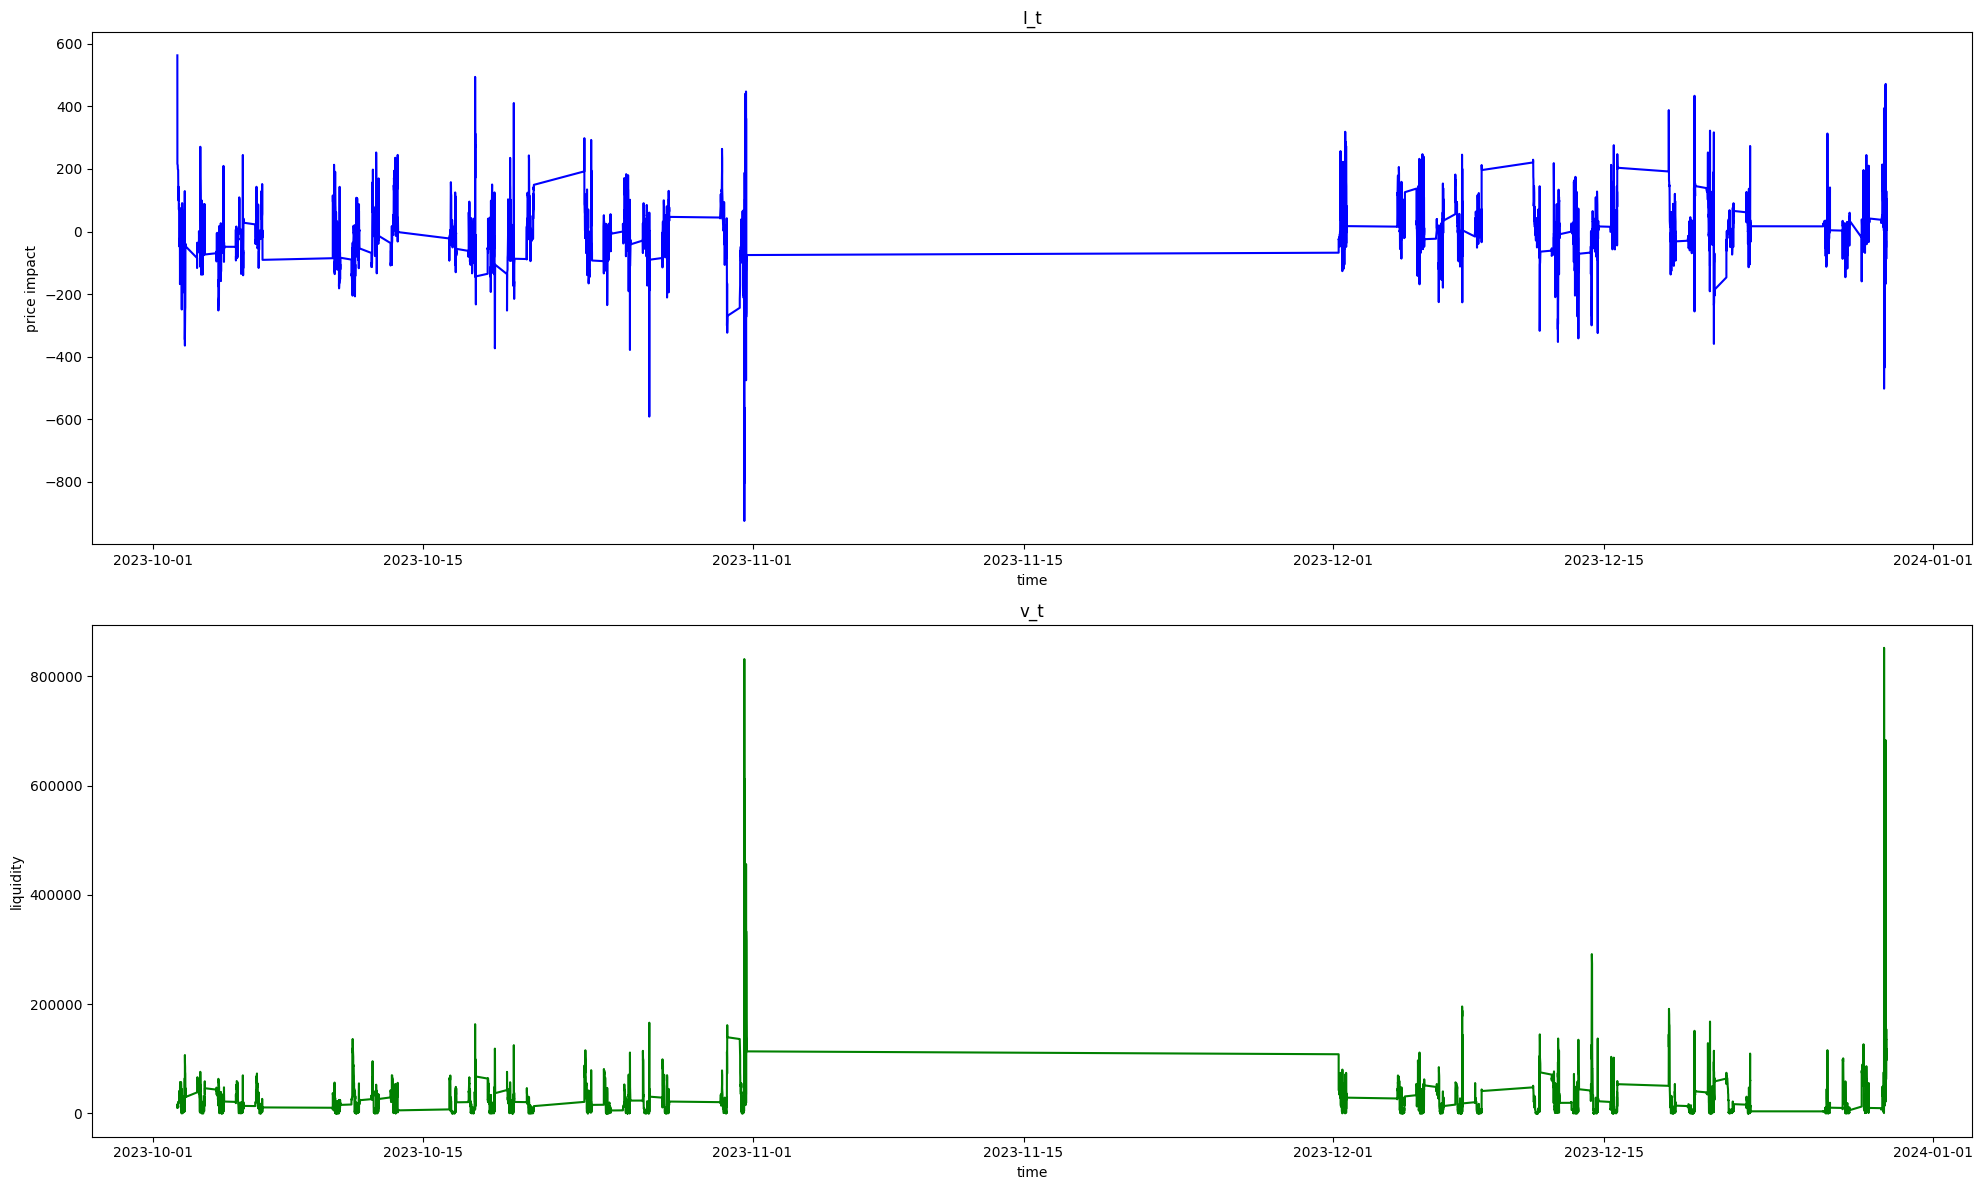

In [145]:
plt.figure(figsize=(20, 12))

# First subplot for df_it.I_t
plt.subplot(2, 1, 1)
plt.plot(df_it.I_t, color='blue')
plt.xlabel('time')
plt.ylabel('price impact')
plt.title('I_t')

# Second subplot for df_it.v_t
plt.subplot(2, 1, 2)
plt.plot(df_it.v_t, color='green')
plt.xlabel('time')
plt.ylabel('liquidity')
plt.title('v_t')

plt.tight_layout()
plt.show()


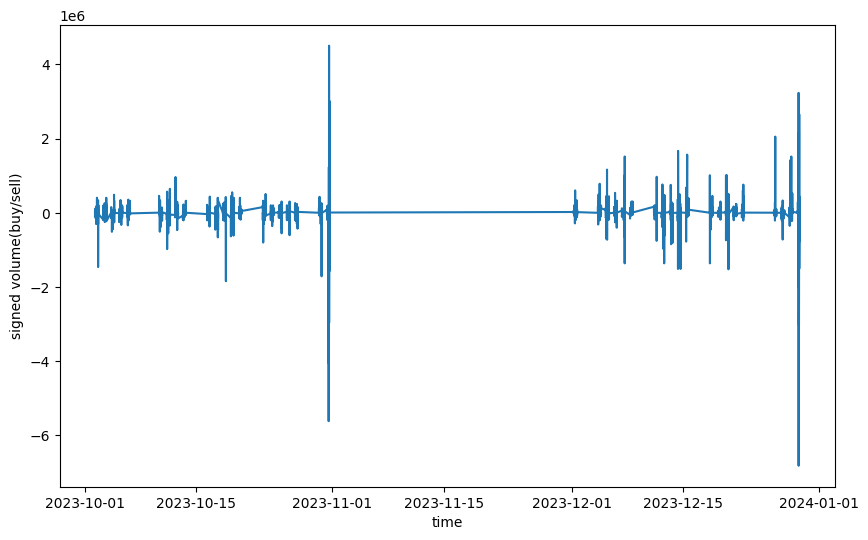

In [147]:
plt.figure(figsize=(10,6))
plt.plot(df_it.SIGNED_VOLUME)
plt.xlabel('time')
plt.ylabel('signed volume(buy/sell)')
plt.show()

### Upper Limited Volume

In [31]:
def ow_with_optimal_volume(data, h_minutes, delta_t=1/24, target_impact=40):
    """
    Calculate impact state I_t, market activity v_t, and optimal trading volume Q_t.

    h_minutes: Time interval for return horizon (in minutes)
    delta_t: Time step for impact decay (in hours)
    target_impact: Desired target impact level (e.g., 40 bps)
    """
    data = data.copy()
    data['ABS_VOLUME'] = data['SIGNED_VOLUME'].abs()

    # Convert h from minutes to hours for beta calculation
    h_hours = h_minutes / 60

    # Calculate beta using half-life transformation
    beta = math.log(2) / h_hours

    # Initialize arrays for impact (I_t), liquidity (v_t), and optimal volume (Q_t)
    I_values = np.zeros(len(data))
    v_values = np.zeros(len(data))
    optimal_Q_values = np.full(len(data), np.nan)  # Placeholder for optimal trading volume

    # Initial values for I_t and v_t
    I_values[0] = data['Daily_Volatility'].iloc[0] * data['SIGNED_VOLUME'].iloc[0] / np.sqrt(data['ADV'].iloc[0])
    v_values[0] = data['ABS_VOLUME'].iloc[0]

    # Exponential moving average with same half-life
    decay_factor = np.exp(-beta * delta_t)  # Using delta_t for decay

    # Iterate over time steps
    for i in range(1, len(data)):
        sigma = data['Daily_Volatility'].iloc[i]
        qt = data['SIGNED_VOLUME'].iloc[i]
        adv = data['ADV'].iloc[i]

        # Update market activity using exponential moving average
        v_values[i] = decay_factor * v_values[i-1] + (1 - decay_factor) * abs(qt)

        # Calculate impact state with flow effects and impact decay
        if adv != 0 and v_values[i] != 0:
            I_values[i] = I_values[i-1] * (1 - beta * delta_t)  # Using delta_t for decay
            I_values[i] += sigma * (qt / np.sqrt(adv * v_values[i]))  # Flow effects

            # Calculate optimal Q_t based on the target impact
            Q_t = (target_impact - I_values[i] * (1 - beta * delta_t)) * np.sqrt(adv * v_values[i]) / sigma
            optimal_Q_values[i] = Q_t
        else:
            I_values[i] = I_values[i-1]  # Carry forward the previous impact state if ADV or v_t is zero

    # Assign calculated arrays back to the DataFrame
    data['I_t'] = I_values
    data['v_t'] = v_values
    data['Optimal_Q_t'] = abs(optimal_Q_values)

    return data

In [32]:
df_it = ow_with_optimal_volume(group1, h_minutes=30, delta_t=1/24)

In [33]:
df_it.head(3)

,DEALER,ACCEPTEDVOL,PRICE,INSTRUMENT,MATURITY_RANGE,MATURITY_DATE,TRADEDATE,COUPON_RATE,SIDE,COMP_ASK,...,SIGNED_VOLUME,Years to Maturity,Spread,Daily_Volatility,ADV,qt,ABS_VOLUME,I_t,v_t,Optimal_Q_t
TIMESTAMP,,,,,,,,,,,,,,,,,,,,,
2023-10-02 06:47:43,D69,11009.0,99.761887,91282CJA0,Note 3.5 - 5.5 Year,2028-09-30,2023-10-02,4.625,BUY,99.769531,...,11009.0,4,0.007812,12.553247,602.570247,-24017.8,11009.0,5629.892547,11009.000000,NaN
2023-10-02 06:47:43,D38,39390.0,99.691574,91282CHV6,Note 1.5 - 3.5 Year,2025-08-31,2023-10-02,5.000,BUY,99.703125,...,39390.0,1,0.005859,12.553247,602.570247,-24017.8,39390.0,5484.137568,12601.903132,1.125537e+06
2023-10-02 06:47:43,D28,2979.5,89.461106,91282CDG3,Note 1.5 - 3.5 Year,2026-10-31,2023-10-02,1.125,BUY,89.488281,...,2979.5,3,0.027344,12.553247,602.570247,-24017.8,2979.5,5181.234950,12061.839142,1.039861e+06


### slippage

In [34]:
# Calculate Slippage
group1['MID'] = (group1['COMP_BID'] + group1['COMP_ASK']) / 2

# Define slippage in bps
def calculate_slippage_bps(row):
    if row['SIDE'] == 'BUY':
        return (row['PRICE'] - row['MID'])/row['MID'] * 10000 # Buy side slippage in bps
    elif row['SIDE'] == 'SELL':
        return (row['MID'] - row['PRICE'])/row['MID'] * 10000 # Sell side slippage in bps
    return None

def calculate_slippage_dollars(row):
    if row['SIDE'] == 'BUY':
        return (row['PRICE'] - row['MID']) # Buy side slippage in $
    elif row['SIDE'] == 'SELL':
        return (row['MID'] - row['PRICE']) # Sell side slippage in $
    return None

group1['Slippage_bps'] = group1.apply(calculate_slippage_bps, axis=1)
group1['Slippage_dollars'] = group1.apply(calculate_slippage_dollars, axis=1)

In [35]:
group1.head(3)

,DEALER,ACCEPTEDVOL,PRICE,INSTRUMENT,MATURITY_RANGE,MATURITY_DATE,TRADEDATE,COUPON_RATE,SIDE,COMP_ASK,...,SIGN,SIGNED_VOLUME,Years to Maturity,Spread,Daily_Volatility,ADV,qt,MID,Slippage_bps,Slippage_dollars
TIMESTAMP,,,,,,,,,,,,,,,,,,,,,
2023-10-02 06:47:43,D69,11009.0,99.761887,91282CJA0,Note 3.5 - 5.5 Year,2028-09-30,2023-10-02,4.625,BUY,99.769531,...,1,11009.0,4,0.007812,12.553247,602.570247,-24017.8,99.761719,0.016840,0.000168
2023-10-02 06:47:43,D38,39390.0,99.691574,91282CHV6,Note 1.5 - 3.5 Year,2025-08-31,2023-10-02,5.000,BUY,99.703125,...,1,39390.0,1,0.005859,12.553247,602.570247,-24017.8,99.697266,-0.570866,-0.005691
2023-10-02 06:47:43,D28,2979.5,89.461106,91282CDG3,Note 1.5 - 3.5 Year,2026-10-31,2023-10-02,1.125,BUY,89.488281,...,1,2979.5,3,0.027344,12.553247,602.570247,-24017.8,89.460938,0.018779,0.000168


## Trading Overview

In [37]:
# Ensure that TRADEDATE is in datetime format
group1['TRADEDATE'] = pd.to_datetime(group1['TRADEDATE'])

# Filter for October data and calculate total slippage cost in dollars
october_data = group1[group1['TRADEDATE'].dt.month == 10]
total_slippage_cost_oct = (october_data['Slippage_dollars'] * october_data['ACCEPTEDVOL']).sum()

# Filter for December data and calculate total slippage cost in dollars
december_data = group1[group1['TRADEDATE'].dt.month == 12]
total_slippage_cost_dec = (december_data['Slippage_dollars'] * december_data['ACCEPTEDVOL']).sum()

# Display the results
print(f"Total Slippage Cost in Dollars for October: ${total_slippage_cost_oct:,.2f}")
print(f"Total Slippage Cost in Dollars for December: ${total_slippage_cost_dec:,.2f}")

Total Slippage Cost in Dollars for October: $2,241,604.13
Total Slippage Cost in Dollars for December: $-5,724,009.44


In [38]:
# total accepted volume
total_accept_vol = group1['ACCEPTEDVOL'].sum()
total_accept_vol

772218487.6

In [39]:
# num of trades
num_of_trades = group1.count()[0]
num_of_trades

47566

In [40]:
# dealer count
dealer_count = len(group1['DEALER'].unique())
dealer_count

32

In [41]:
# notional value
notional = 100 * total_accept_vol
notional

77221848760.0

In [42]:
# weighted avg slippage
group1['Slippage_bps'] = group1.apply(calculate_slippage_bps, axis=1)
group1['Weighted_Slippage'] = group1['Slippage_bps'] * group1['ACCEPTEDVOL']

volume_weighted_slippage = group1['Weighted_Slippage'].sum() / (group1['ACCEPTEDVOL'].sum())
volume_weighted_slippage

0.10943155145373573

In [43]:
# price impact
avg_price_impact = df_it['I_t'].mean()
avg_price_impact

45.07604040119423

In [45]:
note_maturity_ranges = ['Note 0 - 1.5 Year','Note 1.5 - 3.5 Year','Note 3.5 - 5.5 Year','Note 5.5 - 10 Year','Note >10 Year']

# store overview data for each maturity and month
overview_data = []

# Loop through each maturity range and each month (October and December)
for maturity in note_maturity_ranges:
    # Filter the main data (filtered_rawdata) for each maturity range
    group = filtered_rawdata[filtered_rawdata['MATURITY_RANGE'] == maturity]

    # Convert TRADEDATE to datetime if not already
    group['TRADEDATE'] = pd.to_datetime(group['TRADEDATE'])

    for month in [10, 12]:  # October and December
        # Filter by the specific month in the main data
        group_month = group[group['TRADEDATE'].dt.month == month]

        if group_month.empty:
            # Skip if there’s no data for this maturity range and month
            continue

        # Calculate metrics
        total_accept_vol = group_month['ACCEPTEDVOL'].sum()
        num_of_trades = len(group_month)
        dealer_count = group_month['DEALER'].nunique()
        notional = 100 * total_accept_vol  # Notional value as 100 times the accepted volume

        # Calculate volume-weighted slippage
        group_month['MID'] = (group_month['COMP_ASK'] + group_month['COMP_BID']) / 2
        group_month['Slippage_bps'] = group_month.apply(calculate_slippage_bps, axis=1)
        group_month['Weighted_Slippage'] = group_month['Slippage_bps'] * group_month['ACCEPTEDVOL']

        volume_weighted_slippage = group_month['Weighted_Slippage'].sum() / total_accept_vol if total_accept_vol > 0 else 0

        # Calculate average price impact from df_it based on maturity range and month
        df_it_maturity_month = df_it[(df_it['MATURITY_RANGE'] == maturity) &
                                     (df_it['TRADEDATE'].dt.month == month)]

        avg_price_impact = df_it_maturity_month['I_t'].mean() if 'I_t' in df_it_maturity_month else 0

        # Check if avg_price_impact is NaN, and handle accordingly
        if pd.isna(avg_price_impact):
            avg_price_impact = 0  # Set to 0 if there are no valid values

        # Store the calculated metrics in the overview data list
        overview_data.append({
            'Maturity Range': maturity,
            'Month': 'October' if month == 10 else 'December',
            'Notional Value': notional,
            'Num of Trades': num_of_trades,
            'Total Accepted Volume': total_accept_vol,
            'Volume Weighted Slippage': volume_weighted_slippage,
            'Avg Price Impact': abs(avg_price_impact),
            'Dealer Count': dealer_count
        })

# Convert the overview data list to a DataFrame
overview_df = pd.DataFrame(overview_data)

# Separate October and December for display
overview_oct = overview_df[overview_df['Month'] == 'October']
overview_dec = overview_df[overview_df['Month'] == 'December']


In [46]:
overview_oct[['Maturity Range',  'Notional Value', 'Num of Trades',
       'Total Accepted Volume', 'Volume Weighted Slippage', 'Avg Price Impact',
       'Dealer Count']]

,Maturity Range,Notional Value,Num of Trades,Total Accepted Volume,Volume Weighted Slippage,Avg Price Impact,Dealer Count
0,Note 0 - 1.5 Year,8.735803e+09,4972,87358029.99,0.273529,3.595182,23
2,Note 1.5 - 3.5 Year,8.824201e+09,5337,88242014.31,0.088455,1.328361,24
4,Note 3.5 - 5.5 Year,7.663586e+09,3899,76635860.90,0.512063,8.105183,24
6,Note 5.5 - 10 Year,7.317549e+09,4545,73175493.84,-0.083820,21.189705,24
8,Note >10 Year,7.019864e+09,4696,70198641.05,3.925085,159.518247,24


In [47]:
overview_dec[['Maturity Range',  'Notional Value', 'Num of Trades',
       'Total Accepted Volume', 'Volume Weighted Slippage', 'Avg Price Impact',
       'Dealer Count']]

,Maturity Range,Notional Value,Num of Trades,Total Accepted Volume,Volume Weighted Slippage,Avg Price Impact,Dealer Count
1,Note 0 - 1.5 Year,7.829091e+09,4983,7.829091e+07,-8.728555,45.170258,20
3,Note 1.5 - 3.5 Year,1.055202e+10,6907,1.055202e+08,0.168188,62.445700,25
5,Note 3.5 - 5.5 Year,5.957014e+09,3762,5.957014e+07,-0.064879,67.371949,23
7,Note 5.5 - 10 Year,7.391046e+09,4215,7.391046e+07,4.684995,65.572531,25
9,Note >10 Year,5.931674e+09,4250,5.931674e+07,1.135837,66.880657,23


## Total Transaction cost

In [164]:
group1['Total_Cost'] = group1['Slippage_dollars'] * group1['ACCEPTEDVOL']

total_cost = group1['Total_Cost'].sum()

print("Total Transaction Cost($):", total_cost)

Total Transaction Cost($): -3482405.3187634377


## Separate the Oct and Dec

In [64]:
# all trade df
group1['MID'] = (group1['COMP_BID'] + group1['COMP_ASK']) / 2
# group1['Slippage_bps'] = group1.apply(calculate_slippage_bps, axis=1)
# group1['Slippage_dollars'] = group1.apply(calculate_slippage_dollars, axis=1)
group1['Notional_Value'] = group1['ACCEPTEDVOL'] * 100

In [58]:
# this only filter trades that either in oct or dec
group1_oct_dec = group1[(group1.index.month == 10) | (group1.index.month == 12)]

# Filter data separately for October and December
group1_oct = group1[group1.index.month == 10]
group1_dec = group1[group1.index.month == 12]

## Define time session intra day

In [ ]:
def assign_time_session(timestamp):
    hour = timestamp.hour
    if 7 <= hour < 9 or (hour == 9 and timestamp.minute < 30):
        return "Pre-market"
    elif 9 <= hour < 12:
        return "Morning"
    elif 12 <= hour < 14:
        return "Mid-day"
    elif 14 <= hour < 16:
        return "Afternoon"
    else:
        return "Post-market"

In [60]:
# assign time session to each trade
group1_oct_dec['Time_Session'] = group1_oct_dec.index.map(assign_time_session)
group1_oct['Time_Session'] = group1_oct.index.map(assign_time_session)
group1_dec['Time_Session'] = group1_dec.index.map(assign_time_session)

In [57]:
group1.head(2)

,DEALER,ACCEPTEDVOL,PRICE,INSTRUMENT,MATURITY_RANGE,MATURITY_DATE,TRADEDATE,COUPON_RATE,SIDE,COMP_ASK,...,SIGNED_VOLUME,Years to Maturity,Spread,Daily_Volatility,ADV,qt,MID,Slippage_bps,Slippage_dollars,Weighted_Slippage
TIMESTAMP,,,,,,,,,,,,,,,,,,,,,
2023-10-02 06:47:43,D69,11009.0,99.761887,91282CJA0,Note 3.5 - 5.5 Year,2028-09-30,2023-10-02,4.625,BUY,99.769531,...,11009.0,4,0.007812,12.553247,602.570247,-24017.8,99.761719,0.016840,0.000168,185.392957
2023-10-02 06:47:43,D38,39390.0,99.691574,91282CHV6,Note 1.5 - 3.5 Year,2025-08-31,2023-10-02,5.000,BUY,99.703125,...,39390.0,1,0.005859,12.553247,602.570247,-24017.8,99.697266,-0.570866,-0.005691,-22486.400188


In [65]:
# all trade df
group1['MID'] = (group1['COMP_BID'] + group1['COMP_ASK']) / 2
# group1['Slippage_bps'] = group1.apply(calculate_slippage_bps, axis=1)
# group1['Slippage_dollars'] = group1.apply(calculate_slippage_dollars, axis=1)
group1['Notional_Value'] = group1['ACCEPTEDVOL'] * 100

group1_oct = group1[group1.index.month == 10]
group1_dec = group1[group1.index.month == 12]
group1_oct['Time_Session'] = group1_oct.index.map(assign_time_session)
group1_dec['Time_Session'] = group1_dec.index.map(assign_time_session)

# oct trades df
group1_oct['Weighted_Slippage'] = group1_oct['Slippage_bps'] * group1_oct['ACCEPTEDVOL']
group1_oct['Weighted_Slippage_dollars'] = group1_oct['Slippage_dollars'] * group1_oct['ACCEPTEDVOL']

# October volume-weighted average slippage
volume_weighted_slippage_oct = group1_oct.groupby('Time_Session').apply(
    lambda x: x['Weighted_Slippage_dollars'].sum() / (x['ACCEPTEDVOL'].abs().sum())
).rename('Volume_Weighted_Slippage_bps_Oct')

# dec trads df
group1_dec['Weighted_Slippage'] = group1_dec['Slippage_bps'] * group1_dec['ACCEPTEDVOL']
group1_dec['Weighted_Slippage_dollars'] = group1_dec['Slippage_dollars'] * group1_dec['ACCEPTEDVOL']

#  December volume-weighted average slippage
volume_weighted_slippage_dec = group1_dec.groupby('Time_Session').apply(
    lambda x: x['Weighted_Slippage_dollars'].sum() / (x['SIGNED_VOLUME'].abs().sum())
).rename('Volume_Weighted_Slippage_bps_Dec')


notional_oct = group1_dec.groupby('Time_Session').apply(
    lambda x: x['Notional_Value'].sum()
).rename('Notional_Value_oct')

notional_dec = group1_dec.groupby('Time_Session').apply(
    lambda x: x['Notional_Value'].sum()
).rename('Notional_Value_dec')


In [66]:
print("Volume-Weighted Slippage for October:")
print(volume_weighted_slippage_oct)

Volume-Weighted Slippage for October:
Time_Session
Afternoon      0.016315
Mid-day        0.000992
Morning        0.001385
Post-market    0.000700
Pre-market     0.001054
Name: Volume_Weighted_Slippage_bps_Oct, dtype: float64


In [67]:
print('Notional Value for October:')
print(notional_oct)

Notional Value for October:
Time_Session
Afternoon      5.350395e+09
Mid-day        1.202906e+10
Morning        7.968037e+09
Post-market    8.167305e+09
Pre-market     4.146043e+09
Name: Notional_Value_oct, dtype: float64


In [68]:
print("\nVolume-Weighted Slippage for December:")
print(volume_weighted_slippage_dec)


Volume-Weighted Slippage for December:
Time_Session
Afternoon      0.008437
Mid-day        0.005749
Morning       -0.085707
Post-market   -0.001070
Pre-market     0.001196
Name: Volume_Weighted_Slippage_bps_Dec, dtype: float64


In [69]:
print('Notional Value for December:')
print(notional_dec)

Notional Value for December:
Time_Session
Afternoon      5.350395e+09
Mid-day        1.202906e+10
Morning        7.968037e+09
Post-market    8.167305e+09
Pre-market     4.146043e+09
Name: Notional_Value_dec, dtype: float64


apply simialar steps for df_it

In [70]:
# Filter the data for October and December
df_oct_dec = df_it[(df_it.index.month == 10) | (df_it.index.month == 12)]

df_oct_dec['Time_Session'] = df_oct_dec.index.map(assign_time_session)

# Calculate Signed Volume Weighted Price Impact
df_oct_dec['Signed_Volume_Weighted_Impact'] = df_oct_dec['I_t'] #* df_oct_dec['SIGNED_VOLUME']

In [71]:
# Extract month and year for grouping
df_oct_dec['Year_Month'] = df_oct_dec.index.to_period('M')  # Group by month and year

# Group by Year_Month and Time_Session for monthly session-based metrics
session_metrics_monthly = df_oct_dec.groupby(['Year_Month', 'Time_Session']).agg(
    # AcceptedVol = ('ACCEPTEDVOL', 'sum'),
    Total_Signed_Volume=('SIGNED_VOLUME', 'sum'),
    Total_Signed_Volume_Weighted_Impact=('Signed_Volume_Weighted_Impact', 'mean')
)

# Calculate the signed volume weighted price impact for each session
session_metrics_monthly['Signed_Volume_Weighted_Price_Impact'] = (
    session_metrics_monthly['Total_Signed_Volume_Weighted_Impact'] #/ session_metrics_monthly['AcceptedVol']
)

# Display the results for October and December
session_metrics_monthly[['Signed_Volume_Weighted_Price_Impact', 'Total_Signed_Volume']]

Signed_Volume_Weighted_Price_Impact  \
Year_Month Time_Session                                        
2023-10    Afternoon                               20.786022   
           Mid-day                                -81.579164   
           Morning                                -14.721404   
           Post-market                            124.152446   
           Pre-market                              51.972127   
2023-12    Afternoon                              119.432389   
           Mid-day                                111.892261   
           Morning                                 47.630268   
           Post-market                            -28.411661   
           Pre-market                             330.957590   

                         Total_Signed_Volume  
Year_Month Time_Session                       
2023-10    Afternoon             13890300.73  
           Mid-day              -23841900.42  
           Morning               -2143069.51  
           Post-market           -8788904.86  
           Pre-market             5620067.23  
2023-12    Afternoon             11390707.28  
           Mid-day               29195428.65  
           Morning               -3452544.61  
           Post-market           -7909316.06  
           Pre-market            10813056.97

## Dashboard1: market session

In [ ]:
# Define necessary columns in `group1`
group1['Year_Month'] = group1.index.to_period('M').astype(str)
group1['Time_Session'] = group1.index.map(assign_time_session)
group1['Weighted_Slippage'] = group1['Slippage_bps'] * group1['ACCEPTEDVOL']
group1['Weighted_Slippage_dollars'] = group1['Slippage_dollars'] * group1['ACCEPTEDVOL']
group1['Notional_Value'] = group1['ACCEPTEDVOL'] * 100

# Calculate metrics by grouping `group1` by `Year_Month`, `Time_Session`, and `MATURITY_RANGE`
volume_weighted_slippage = group1.groupby(['Year_Month', 'Time_Session', 'MATURITY_RANGE']).apply(
    lambda x: x['Weighted_Slippage'].sum() / (x['ACCEPTEDVOL'].abs().sum())
).rename('Volume_Weighted_Slippage')

notional_value = group1.groupby(['Year_Month', 'Time_Session', 'MATURITY_RANGE'])['Notional_Value'].sum().rename('Notional_Value')
accepted_volume = group1.groupby(['Year_Month', 'Time_Session', 'MATURITY_RANGE'])['ACCEPTEDVOL'].sum().rename('Total_Accepted_Volume')
dealer_count = group1.groupby(['Year_Month', 'Time_Session', 'MATURITY_RANGE'])['DEALER'].nunique().rename('Dealer_Count')
num_of_trades = group1.groupby(['Year_Month', 'Time_Session', 'MATURITY_RANGE']).size().rename('Num_of_Trades')  # Number of trades

# Combine metrics into `combined_data`
combined_data = pd.DataFrame({
    'Volume_Weighted_Slippage': volume_weighted_slippage,
    'Notional_Value': notional_value,
    'Total_Accepted_Volume': accepted_volume,
    'Dealer_Count': dealer_count,
    'Num_of_Trades': num_of_trades
}).reset_index()

# Filter `df_it` for October and December data
df_oct_dec = df_it[(df_it.index.month == 10) | (df_it.index.month == 12)]
df_oct_dec['Time_Session'] = df_oct_dec.index.map(assign_time_session)
df_oct_dec['Signed_Volume_Weighted_Impact'] = df_oct_dec['I_t']  # Weighted impact by signed volume
df_oct_dec['Upper_Limited_Volume'] = df_oct_dec['Optimal_Q_t']
df_oct_dec['Year_Month'] = df_oct_dec.index.to_period('M').astype(str)

# Group by `Year_Month`, `Time_Session`, and `MATURITY_RANGE` for session-based metrics
session_metrics_monthly = df_oct_dec.groupby(['Year_Month', 'Time_Session', 'MATURITY_RANGE']).agg(
    Total_Signed_Volume=('SIGNED_VOLUME', 'sum'),
    Price_Impact=('Signed_Volume_Weighted_Impact', 'mean'),
    Upper_Limited_Volume=('Upper_Limited_Volume', 'mean')
).reset_index()

# Ensure `Year_Month` is in string format for merging
session_metrics_monthly['Year_Month'] = session_metrics_monthly['Year_Month'].astype(str)
combined_data['Year_Month'] = combined_data['Year_Month'].astype(str)

# Merge session metrics with combined data
final_table = session_metrics_monthly.merge(
    combined_data, on=['Year_Month', 'Time_Session', 'MATURITY_RANGE'], how='left'
)

# Check final column names to confirm they exist
print("Columns in final_table before selection:", final_table.columns)

# Convert Price Impact and Volume Weighted Slippage to basis points for readability
final_table['Price_Impact_bps'] = final_table['Price_Impact'].abs()
final_table['Volume_Weighted_Slippage_bps'] = final_table['Volume_Weighted_Slippage']

# Select and rename columns to match the desired output format
final_table = final_table[['MATURITY_RANGE', 'Time_Session', 'Notional_Value',
                           'Total_Accepted_Volume', 'Num_of_Trades', 'Price_Impact_bps',
                           'Volume_Weighted_Slippage_bps', 'Upper_Limited_Volume']]

# Rename columns to match the format in the provided table
final_table.columns = ['Maturity Range', 'Session', 'Total Notional Value ($)',
                       'Total Accepted Volume', '# of Trades', 'Avg Price Impact (bps)',
                       'Volume Weighted Slippage (bps)', 'Upper Limited Volume']

# Reset index for a cleaner display
final_table.reset_index(drop=True, inplace=True)

# Display the final formatted table
print(final_table)


Columns in final_table before selection: Index(['Year_Month', 'Time_Session', 'MATURITY_RANGE', 'Total_Signed_Volume',
       'Price_Impact', 'Upper_Limited_Volume', 'Volume_Weighted_Slippage',
       'Notional_Value', 'Total_Accepted_Volume', 'Dealer_Count',
       'Num_of_Trades'],
      dtype='object')
         Maturity Range      Session  Total Notional Value ($)  \
0     Note 0 - 1.5 Year    Afternoon              1.549458e+09   
1   Note 1.5 - 3.5 Year    Afternoon              3.150259e+09   
2   Note 3.5 - 5.5 Year    Afternoon              2.388883e+09   
3    Note 5.5 - 10 Year    Afternoon              2.208553e+09   
4         Note >10 Year    Afternoon              2.939863e+09   
5     Note 0 - 1.5 Year      Mid-day              2.389261e+09   
6   Note 1.5 - 3.5 Year      Mid-day              4.347166e+08   
7   Note 3.5 - 5.5 Year      Mid-day              5.016147e+08   
8    Note 5.5 - 10 Year      Mid-day              5.578004e+08   
9         Note >10 Year      Mid-

In [173]:
best_sessions = final_table.loc[final_table.groupby('Maturity Range')['Volume Weighted Slippage (bps)'].idxmin()].copy()
worst_sessions = final_table.loc[final_table.groupby('Maturity Range')['Volume Weighted Slippage (bps)'].idxmax()].copy()

# Add a column to indicate if it is the best or worst session
best_sessions['Best/Worst'] = 'best'
worst_sessions['Best/Worst'] = 'worst'

# Combine best and worst sessions into a single summary table
summary_table = pd.concat([best_sessions, worst_sessions])

# Reorder and rename columns to match the desired output format
summary_table = summary_table[['Maturity Range', 'Best/Worst', 'Session', 'Total Notional Value ($)',
                               'Total Accepted Volume', '# of Trades', 'Avg Price Impact (bps)',
                               'Volume Weighted Slippage (bps)', 'Upper Limited Volume']]

# Sort by 'Maturity Range' for easier readability
summary_table = summary_table.sort_values(by=['Maturity Range', 'Best/Worst'])

# Reset index for a cleaner display
summary_table.reset_index(drop=True, inplace=True)

In [174]:
import pandas as pd

# Define necessary columns in `group1`
group1['Year_Month'] = group1.index.to_period('M').astype(str)
group1['Time_Session'] = group1.index.map(assign_time_session)
group1['Weighted_Slippage'] = group1['Slippage_bps'] * group1['ACCEPTEDVOL']
group1['Weighted_Slippage_dollars'] = group1['Slippage_dollars'] * group1['ACCEPTEDVOL']
group1['Notional_Value'] = group1['ACCEPTEDVOL'] * 100

# Calculate metrics by grouping `group1` by `Year_Month`, `Time_Session`, and `MATURITY_RANGE`
volume_weighted_slippage = group1.groupby(['Year_Month', 'Time_Session', 'MATURITY_RANGE']).apply(
    lambda x: x['Weighted_Slippage'].sum() / (x['ACCEPTEDVOL'].abs().sum())
).rename('Volume_Weighted_Slippage')

volume_weighted_slippage_dollars = group1.groupby(['Year_Month', 'Time_Session', 'MATURITY_RANGE']).apply(
    lambda x: x['Weighted_Slippage_dollars'].sum() / (x['ACCEPTEDVOL'].abs().sum())
).rename('Volume_Weighted_Slippage_dollars')

notional_value = group1.groupby(['Year_Month', 'Time_Session', 'MATURITY_RANGE'])['Notional_Value'].sum().rename('Notional_Value')
accepted_volume = group1.groupby(['Year_Month', 'Time_Session', 'MATURITY_RANGE'])['ACCEPTEDVOL'].sum().rename('Total_Accepted_Volume')
dealer_count = group1.groupby(['Year_Month', 'Time_Session', 'MATURITY_RANGE'])['DEALER'].nunique().rename('Dealer_Count')
num_of_trades = group1.groupby(['Year_Month', 'Time_Session', 'MATURITY_RANGE']).size().rename('Num_of_Trades')

# Combine metrics into `combined_data`
combined_data = pd.DataFrame({
    'Volume_Weighted_Slippage': volume_weighted_slippage,
    'Volume_Weighted_Slippage_dollars': volume_weighted_slippage_dollars,
    'Notional_Value': notional_value,
    'Total_Accepted_Volume': accepted_volume,
    'Dealer_Count': dealer_count,
    'Num_of_Trades': num_of_trades
}).reset_index()

# Filter `df_it` for October and December data
df_oct_dec = df_it[(df_it.index.month == 10) | (df_it.index.month == 12)]
df_oct_dec['Time_Session'] = df_oct_dec.index.map(assign_time_session)
df_oct_dec['Signed_Volume_Weighted_Impact'] = df_oct_dec['I_t']
df_oct_dec['Upper_Limited_Volume'] = df_oct_dec['Optimal_Q_t']
df_oct_dec['Year_Month'] = df_oct_dec.index.to_period('M').astype(str)

# Group by `Year_Month`, `Time_Session`, and `MATURITY_RANGE` for session-based metrics
session_metrics_monthly = df_oct_dec.groupby(['Year_Month', 'Time_Session', 'MATURITY_RANGE']).agg(
    Total_Signed_Volume=('SIGNED_VOLUME', 'sum'),
    Price_Impact=('Signed_Volume_Weighted_Impact', 'mean'),
    Upper_Limited_Volume=('Upper_Limited_Volume', 'mean')
).reset_index()

# Ensure `Year_Month` is in string format for merging
session_metrics_monthly['Year_Month'] = session_metrics_monthly['Year_Month'].astype(str)
combined_data['Year_Month'] = combined_data['Year_Month'].astype(str)

# Merge session metrics with combined data
final_table = session_metrics_monthly.merge(
    combined_data, on=['Year_Month', 'Time_Session', 'MATURITY_RANGE'], how='left'
)

# Calculate Price Impact and Volume Weighted Slippage in basis points and add the Upper Limit column
final_table['Price_Impact_bps'] = final_table['Price_Impact'].abs()
final_table['Volume_Weighted_Slippage_bps'] = final_table['Volume_Weighted_Slippage']
final_table['Upper_Limit'] = final_table['Num_of_Trades'] * final_table['Upper_Limited_Volume']

# Select and rename columns to match the desired output format
final_table = final_table[['MATURITY_RANGE', 'Time_Session', 'Notional_Value',
                           'Total_Accepted_Volume','Num_of_Trades', 'Price_Impact_bps',
                           'Volume_Weighted_Slippage_bps','Volume_Weighted_Slippage_dollars', 'Upper_Limit']]

# Rename columns to match the format in the provided table
final_table.columns = ['Maturity Range', 'Session', 'Total Notional Value ($)',
                       'Total Accepted Volume', '# of Trades', 'Avg Price Impact (bps)',
                       'Volume Weighted Slippage (bps)', 'Volume_Weighted_Slippage_dollars', 'Upper Limit']

# Identify best and worst sessions based on Volume Weighted Slippage (bps) for each maturity range
best_sessions = final_table.loc[final_table.groupby('Maturity Range')['Volume Weighted Slippage (bps)'].idxmin()].copy()
worst_sessions = final_table.loc[final_table.groupby('Maturity Range')['Volume Weighted Slippage (bps)'].idxmax()].copy()

# Check for cases where the best and worst sessions might be identical
for maturity in best_sessions['Maturity Range'].unique():
    best_session = best_sessions[best_sessions['Maturity Range'] == maturity]
    worst_session = worst_sessions[worst_sessions['Maturity Range'] == maturity]

    # If the session name or ID is the same in both best and worst, we need to replace the worst session
    if best_session['Session'].values[0] == worst_session['Session'].values[0]:
        # Remove the identical worst session
        worst_sessions = worst_sessions[worst_sessions['Maturity Range'] != maturity]

        # Select the session with the second-highest slippage as the new worst session
        possible_worst_sessions = final_table[final_table['Maturity Range'] == maturity]
        second_worst = possible_worst_sessions.sort_values(by='Volume Weighted Slippage (bps)', ascending=False).iloc[1]

        # Add the second-worst session to the worst_sessions DataFrame
        worst_sessions = pd.concat([worst_sessions, second_worst.to_frame().T])

# Add a column to indicate if it is the best or worst session
best_sessions['Best/Worst'] = 'best'
worst_sessions['Best/Worst'] = 'worst'
# Reset index for the combined summary table
summary_table = pd.concat([best_sessions, worst_sessions]).sort_values(by=['Maturity Range', 'Best/Worst']).reset_index(drop=True)


# Calculate the transferrable volume and savings for each maturity range, but only for the best session
transferrable_volumes = []
savings = []
for maturity in best_sessions['Maturity Range'].unique():
    best_session = best_sessions[best_sessions['Maturity Range'] == maturity]
    worst_session = worst_sessions[worst_sessions['Maturity Range'] == maturity]

    if not best_session.empty and not worst_session.empty:
        transferrable_volume = min(
            best_session['Upper Limit'].values[0] - best_session['Total Accepted Volume'].values[0],
            worst_session['Total Accepted Volume'].values[0]
        )

        # Calculate savings based on slippage difference for the best session only
        slippage_diff_dollars = worst_session['Volume_Weighted_Slippage_dollars'].values[0] - best_session['Volume_Weighted_Slippage_dollars'].values[0]
        savings_value = transferrable_volume * slippage_diff_dollars

        # Append the transferrable volume and savings for the best session, and 0 savings for the worst session
        transferrable_volumes.extend([transferrable_volume, 0])
        savings.extend([savings_value, 0])
    else:
        # If there is no matching best and worst session, append 0 for both
        transferrable_volumes.extend([0, 0])
        savings.extend([0, 0])

# Add transferrable volume and savings to summary table
summary_table = pd.concat([best_sessions, worst_sessions]).sort_values(by=['Maturity Range', 'Best/Worst']).reset_index(drop=True)
summary_table['Transferrable Volume'] = transferrable_volumes
summary_table['Savings ($)'] = savings

# Display the final summary table
print(summary_table)

        Maturity Range      Session Total Notional Value ($)  \
0    Note 0 - 1.5 Year      Morning             2698387912.0   
1    Note 0 - 1.5 Year      Mid-day             2914106035.0   
2  Note 1.5 - 3.5 Year      Mid-day              434716625.0   
3  Note 1.5 - 3.5 Year   Pre-market             1160907029.0   
4  Note 3.5 - 5.5 Year      Morning              868094596.0   
5  Note 3.5 - 5.5 Year    Afternoon             2388883108.0   
6   Note 5.5 - 10 Year  Post-market             1710677501.0   
7   Note 5.5 - 10 Year      Mid-day             2729610345.0   
8        Note >10 Year   Pre-market              282273992.0   
9        Note >10 Year    Afternoon             2939863459.0   

  Total Accepted Volume # of Trades Avg Price Impact (bps)  \
0           26983879.12        1213              18.233231   
1           29141060.35        1237              83.196831   
2            4347166.25        1090              69.634359   
3           11609070.29         251            

In [175]:
summary_table.columns

Index(['Maturity Range', 'Session', 'Total Notional Value ($)',
       'Total Accepted Volume', '# of Trades', 'Avg Price Impact (bps)',
       'Volume Weighted Slippage (bps)', 'Volume_Weighted_Slippage_dollars',
       'Upper Limit', 'Best/Worst', 'Transferrable Volume', 'Savings ($)'],
      dtype='object')

In [176]:
summary_table = summary_table[['Maturity Range', 'Best/Worst', 'Session', 'Total Notional Value ($)',
       'Total Accepted Volume', '# of Trades', 'Avg Price Impact (bps)',
       'Volume Weighted Slippage (bps)',
       'Upper Limit', 'Transferrable Volume', 'Savings ($)']]

# Set 'Maturity Range' as the index
summary_table.set_index(['Maturity Range', 'Best/Worst'], inplace=True)

# Display the table to verify
summary_table

Session Total Notional Value ($)  \
Maturity Range      Best/Worst                                         
Note 0 - 1.5 Year   best            Morning             2698387912.0   
                    worst           Mid-day             2914106035.0   
Note 1.5 - 3.5 Year best            Mid-day              434716625.0   
                    worst        Pre-market             1160907029.0   
Note 3.5 - 5.5 Year best            Morning              868094596.0   
                    worst         Afternoon             2388883108.0   
Note 5.5 - 10 Year  best        Post-market             1710677501.0   
                    worst           Mid-day             2729610345.0   
Note >10 Year       best         Pre-market              282273992.0   
                    worst         Afternoon             2939863459.0   

                               Total Accepted Volume # of Trades  \
Maturity Range      Best/Worst                                     
Note 0 - 1.5 Year   best                 26983879.12        1213   
                    worst                29141060.35        1237   
Note 1.5 - 3.5 Year best                  4347166.25        1090   
                    worst                11609070.29         251   
Note 3.5 - 5.5 Year best                  8680945.96        1116   
                    worst                23888831.08         594   
Note 5.5 - 10 Year  best                 17106775.01        1189   
                    worst                27296103.45        1137   
Note >10 Year       best                  2822739.92         150   
                    worst                29398634.59         859   

                               Avg Price Impact (bps)  \
Maturity Range      Best/Worst                          
Note 0 - 1.5 Year   best                    18.233231   
                    worst                   83.196831   
Note 1.5 - 3.5 Year best                    69.634359   
                    worst                  266.780228   
Note 3.5 - 5.5 Year best                    80.518769   
                    worst                   13.767637   
Note 5.5 - 10 Year  best                    56.353454   
                    worst                  124.791553   
Note >10 Year       best                   117.626644   
                    worst                  312.379641   

                               Volume Weighted Slippage (bps)  \
Maturity Range      Best/Worst                                  
Note 0 - 1.5 Year   best                           -26.238513   
                    worst                            0.717307   
Note 1.5 - 3.5 Year best                            -0.185425   
                    worst                             0.26099   
Note 3.5 - 5.5 Year best                            -0.347003   
                    worst                            1.480297   
Note 5.5 - 10 Year  best                            -0.468806   
                    worst                           12.937302   
Note >10 Year       best                            -0.306228   
                    worst                             9.16997   

                                     Upper Limit  Transferrable Volume  \
Maturity Range      Best/Worst                                           
Note 0 - 1.5 Year   best        141976059.106166           29141060.35   
                    worst       143149087.563744                  0.00   
Note 1.5 - 3.5 Year best        155101968.667222           11609070.29   
                    worst        59384744.915988                  0.00   
Note 3.5 - 5.5 Year best         120668152.74538           23888831.08   
                    worst       157231272.937609                  0.00   
Note 5.5 - 10 Year  best        110309843.161411           27296103.45   
                    worst       138427477.533264                  0.00   
Note >10 Year       best         38609689.110892           29398634.59   
                    worst       282298132.316094                  0.00   


In [ ]:
# Ensure `Year_Month` column is defined in both `group1` and `df_it`
group1['Year_Month'] = group1.index.to_period('M').astype(str)
df_it['Year_Month'] = df_it.index.to_period('M').astype(str)

def calculate_summary_table_for_month(group1, df_it, month):
    # Filter data for the specified month only
    group1_month = group1[group1['Year_Month'] == month]
    df_it_month = df_it[df_it['Year_Month'] == month]

    # Define necessary columns in `group1_month`
    group1_month['Time_Session'] = group1_month.index.map(assign_time_session)
    group1_month['Weighted_Slippage'] = group1_month['Slippage_bps'] * group1_month['ACCEPTEDVOL']
    group1_month['Weighted_Slippage_dollars'] = group1_month['Slippage_dollars'] * group1_month['ACCEPTEDVOL']
    group1_month['Notional_Value'] = group1_month['ACCEPTEDVOL'] * 100

    # Calculate metrics by grouping `group1_month` by `Time_Session` and `MATURITY_RANGE`
    volume_weighted_slippage = group1_month.groupby(['Time_Session', 'MATURITY_RANGE']).apply(
        lambda x: x['Weighted_Slippage'].sum() / (x['ACCEPTEDVOL'].abs().sum())
    ).rename('Volume_Weighted_Slippage')

    volume_weighted_slippage_dollars = group1_month.groupby(['Time_Session', 'MATURITY_RANGE']).apply(
        lambda x: x['Weighted_Slippage_dollars'].sum() / (x['ACCEPTEDVOL'].abs().sum())
    ).rename('Volume_Weighted_Slippage_dollars')

    notional_value = group1_month.groupby(['Time_Session', 'MATURITY_RANGE'])['Notional_Value'].sum().rename('Notional_Value')
    accepted_volume = group1_month.groupby(['Time_Session', 'MATURITY_RANGE'])['ACCEPTEDVOL'].sum().rename('Total_Accepted_Volume')
    dealer_count = group1_month.groupby(['Time_Session', 'MATURITY_RANGE'])['DEALER'].nunique().rename('Dealer_Count')
    num_of_trades = group1_month.groupby(['Time_Session', 'MATURITY_RANGE']).size().rename('Num_of_Trades')

    # Combine metrics into `combined_data`
    combined_data = pd.DataFrame({
        'Volume_Weighted_Slippage': volume_weighted_slippage,
        'Volume_Weighted_Slippage_dollars': volume_weighted_slippage_dollars,
        'Notional_Value': notional_value,
        'Total_Accepted_Volume': accepted_volume,
        'Dealer_Count': dealer_count,
        'Num_of_Trades': num_of_trades
    }).reset_index()

    # Define necessary columns in `df_it_month`
    df_it_month['Time_Session'] = df_it_month.index.map(assign_time_session)
    df_it_month['Signed_Volume_Weighted_Impact'] = df_it_month['I_t']
    df_it_month['Upper_Limited_Volume'] = df_it_month['Optimal_Q_t']

    # Group by `Time_Session` and `MATURITY_RANGE` for session-based metrics in the specified month
    session_metrics_monthly = df_it_month.groupby(['Time_Session', 'MATURITY_RANGE']).agg(
        Total_Signed_Volume=('SIGNED_VOLUME', 'sum'),
        Price_Impact=('Signed_Volume_Weighted_Impact', 'mean'),
        Upper_Limited_Volume=('Upper_Limited_Volume', 'mean')
    ).reset_index()

    # Merge session metrics with combined data for the specified month
    final_table = session_metrics_monthly.merge(
        combined_data, on=['Time_Session', 'MATURITY_RANGE'], how='left'
    )

    # Calculate Price Impact and Volume Weighted Slippage in basis points and add the Upper Limit column
    final_table['Price_Impact_bps'] = final_table['Price_Impact'].abs()
    final_table['Volume_Weighted_Slippage_bps'] = final_table['Volume_Weighted_Slippage']
    final_table['Upper_Limit'] = final_table['Num_of_Trades'] * final_table['Upper_Limited_Volume']

    # Select and rename columns to match the desired output format
    final_table = final_table[['MATURITY_RANGE', 'Time_Session', 'Notional_Value',
                               'Total_Accepted_Volume', 'Num_of_Trades', 'Price_Impact_bps',
                               'Volume_Weighted_Slippage_bps', 'Volume_Weighted_Slippage_dollars', 'Upper_Limit']]

    # Rename columns to match the final format
    final_table.columns = ['Maturity Range', 'Session', 'Total Notional Value ($)',
                           'Total Accepted Volume', '# of Trades', 'Avg Price Impact (bps)',
                           'Volume Weighted Slippage (bps)', 'Volume_Weighted_Slippage_dollars', 'Upper Limit']

    # Identify best and worst sessions based on Volume Weighted Slippage (bps) for each maturity range
    best_sessions = final_table.loc[final_table.groupby('Maturity Range')['Volume Weighted Slippage (bps)'].idxmin()].copy()
    worst_sessions = final_table.loc[final_table.groupby('Maturity Range')['Volume Weighted Slippage (bps)'].idxmax()].copy()

    # Check for cases where the best and worst sessions might be identical
    for maturity in best_sessions['Maturity Range'].unique():
        best_session = best_sessions[best_sessions['Maturity Range'] == maturity]
        worst_session = worst_sessions[worst_sessions['Maturity Range'] == maturity]

        # If the session name or ID is the same in both best and worst, replace the worst session
        if best_session['Session'].values[0] == worst_session['Session'].values[0]:
            worst_sessions = worst_sessions[worst_sessions['Maturity Range'] != maturity]
            possible_worst_sessions = final_table[final_table['Maturity Range'] == maturity]
            second_worst = possible_worst_sessions.sort_values(by='Volume Weighted Slippage (bps)', ascending=False).iloc[1]
            worst_sessions = pd.concat([worst_sessions, second_worst.to_frame().T])

    # Add a column to indicate if it is the best or worst session
    best_sessions['Best/Worst'] = 'best'
    worst_sessions['Best/Worst'] = 'worst'

    # Calculate the transferrable volume and savings for each maturity range, but only for the best session
    transferrable_volumes = []
    savings = []
    for maturity in best_sessions['Maturity Range'].unique():
        best_session = best_sessions[best_sessions['Maturity Range'] == maturity]
        worst_session = worst_sessions[worst_sessions['Maturity Range'] == maturity]

        if not best_session.empty and not worst_session.empty:
            transferrable_volume = min(
                best_session['Upper Limit'].values[0] - best_session['Total Accepted Volume'].values[0],
                worst_session['Total Accepted Volume'].values[0]
            )

            # Calculate savings based on slippage difference for the best session only
            slippage_diff_dollars = worst_session['Volume_Weighted_Slippage_dollars'].values[0] - best_session['Volume_Weighted_Slippage_dollars'].values[0]
            savings_value = transferrable_volume * slippage_diff_dollars

            # Append the transferrable volume and savings for the best session, and 0 savings for the worst session
            transferrable_volumes.extend([transferrable_volume, 0])
            savings.extend([savings_value, 0])
        else:
            transferrable_volumes.extend([0, 0])
            savings.extend([0, 0])

    # Add transferrable volume and savings to summary table
    summary_table = pd.concat([best_sessions, worst_sessions]).sort_values(by=['Maturity Range', 'Best/Worst']).reset_index(drop=True)
    summary_table['Transferrable Volume'] = transferrable_volumes
    summary_table['Savings ($)'] = savings

    return summary_table

# Generate summary tables for October and December
summary_table_oct = calculate_summary_table_for_month(group1, df_it, '2023-10')
summary_table_dec = calculate_summary_table_for_month(group1, df_it, '2023-12')


In [227]:
summary_table_oct

,Maturity Range,Session,Total Notional Value ($),Total Accepted Volume,# of Trades,Avg Price Impact (bps),Volume Weighted Slippage (bps),Volume_Weighted_Slippage_dollars,Upper Limit,Best/Worst,Transferrable Volume,Savings ($)
0,Note 0 - 1.5 Year,Afternoon,1.549458e+09,15494580.69,1133,0.447522,0.060753,0.000580,2.746372e+08,best,5996635.63,6.309639e+04
1,Note 0 - 1.5 Year,Morning,5.996636e+08,5996635.63,1054,4.245291,1.135844,0.011102,5.982049e+07,worst,0.00,0.000000e+00
2,Note 1.5 - 3.5 Year,Mid-day,4.347166e+08,4347166.25,1090,69.634359,-0.185425,-0.001811,1.551020e+08,best,11609070.29,5.366439e+04
3,Note 1.5 - 3.5 Year,Pre-market,1.160907e+09,11609070.29,251,266.780228,0.260990,0.002811,5.938474e+07,worst,0.00,0.000000e+00
4,Note 3.5 - 5.5 Year,Mid-day,5.016147e+08,5016146.82,857,95.219834,-0.108410,-0.001036,8.823462e+07,best,23888831.08,3.203364e+05
5,Note 3.5 - 5.5 Year,Afternoon,2.388883e+09,23888831.08,594,13.767637,1.480297,0.012373,1.572313e+08,worst,0.00,0.000000e+00
6,Note 5.5 - 10 Year,Pre-market,6.907228e+08,6907228.40,159,61.678641,-0.309000,-0.002725,3.408341e+07,best,22085526.58,6.967121e+04
7,Note 5.5 - 10 Year,Afternoon,2.208553e+09,22085526.58,734,121.755573,0.120160,0.000430,1.723097e+08,worst,0.00,0.000000e+00
8,Note >10 Year,Pre-market,2.822740e+08,2822739.92,150,117.626644,-0.306228,-0.001774,3.860969e+07,best,29398634.59,1.679467e+06
9,Note >10 Year,Afternoon,2.939863e+09,29398634.59,859,312.379641,9.169970,0.055354,2.822981e+08,worst,0.00,0.000000e+00


In [228]:
summary_table_dec

,Maturity Range,Session,Total Notional Value ($),Total Accepted Volume,# of Trades,Avg Price Impact (bps),Volume Weighted Slippage (bps),Volume_Weighted_Slippage_dollars,Upper Limit,Best/Worst,Transferrable Volume,Savings ($)
0,Note 0 - 1.5 Year,Morning,2.698388e+09,26983879.12,1213,18.233231,-26.238513,-0.253003,1.419761e+08,best,29141060.35,7.577868e+06
1,Note 0 - 1.5 Year,Mid-day,2.914106e+09,29141060.35,1237,83.196831,0.717307,0.007038,1.431491e+08,worst,0.00,0.000000e+00
2,Note 1.5 - 3.5 Year,Post-market,2.099799e+09,20997991.91,2204,13.894437,-0.151738,-0.001476,1.940355e+08,best,33830651.95,2.179440e+05
3,Note 1.5 - 3.5 Year,Mid-day,3.383065e+09,33830651.95,1707,93.634690,0.536058,0.004966,1.504464e+08,worst,0.00,0.000000e+00
4,Note 3.5 - 5.5 Year,Morning,8.680946e+08,8680945.96,1116,80.518769,-0.347003,-0.003420,1.206682e+08,best,9793059.99,5.936226e+04
5,Note 3.5 - 5.5 Year,Pre-market,9.793060e+08,9793059.99,142,400.377249,0.286218,0.002642,4.306987e+07,worst,0.00,0.000000e+00
6,Note 5.5 - 10 Year,Post-market,1.710678e+09,17106775.01,1189,56.353454,-0.468806,-0.004080,1.103098e+08,best,27296103.45,3.653661e+05
7,Note 5.5 - 10 Year,Mid-day,2.729610e+09,27296103.45,1137,124.791553,12.937302,0.009305,1.384275e+08,worst,0.00,0.000000e+00
8,Note >10 Year,Post-market,1.969507e+09,19695067.67,1126,78.124529,-0.025999,0.000072,1.875635e+08,best,18238096.21,4.471847e+05
9,Note >10 Year,Afternoon,1.823810e+09,18238096.21,607,258.616044,3.073893,0.024591,1.258834e+08,worst,0.00,0.000000e+00


In [229]:
summary_table_oct.columns

Index(['Maturity Range', 'Session', 'Total Notional Value ($)',
       'Total Accepted Volume', '# of Trades', 'Avg Price Impact (bps)',
       'Volume Weighted Slippage (bps)', 'Volume_Weighted_Slippage_dollars',
       'Upper Limit', 'Best/Worst', 'Transferrable Volume', 'Savings ($)'],
      dtype='object')

In [230]:
summary_table_oct['Savings ($)'].sum()

2186235.5861620405

In [231]:
summary_table_dec['Savings ($)'].sum()

8667724.655489597

In [232]:
summary_table_oct['Total Notional Value ($)'].sum()

12756656025.0

In [233]:
summary_table_dec['Total Notional Value ($)'].sum()

21176363162.0

In [234]:
summary_table_oct['# of Trades'].sum()

6881

In [235]:
summary_table_dec['# of Trades'].sum()

11678

### result 1 -- oct

In [236]:
summary_table_oct= summary_table_oct[['Maturity Range', 'Session', 'Total Notional Value ($)',
       'Total Accepted Volume', '# of Trades', 'Avg Price Impact (bps)',
       'Volume Weighted Slippage (bps)',
       'Upper Limit', 'Best/Worst', 'Transferrable Volume', 'Savings ($)']]
summary_table_oct.set_index(['Maturity Range', 'Best/Worst'], inplace=True)
summary_table_oct

Session  Total Notional Value ($)  \
Maturity Range      Best/Worst                                         
Note 0 - 1.5 Year   best         Afternoon              1.549458e+09   
                    worst          Morning              5.996636e+08   
Note 1.5 - 3.5 Year best           Mid-day              4.347166e+08   
                    worst       Pre-market              1.160907e+09   
Note 3.5 - 5.5 Year best           Mid-day              5.016147e+08   
                    worst        Afternoon              2.388883e+09   
Note 5.5 - 10 Year  best        Pre-market              6.907228e+08   
                    worst        Afternoon              2.208553e+09   
Note >10 Year       best        Pre-market              2.822740e+08   
                    worst        Afternoon              2.939863e+09   

                                Total Accepted Volume  # of Trades  \
Maturity Range      Best/Worst                                       
Note 0 - 1.5 Year   best                  15494580.69         1133   
                    worst                  5996635.63         1054   
Note 1.5 - 3.5 Year best                   4347166.25         1090   
                    worst                 11609070.29          251   
Note 3.5 - 5.5 Year best                   5016146.82          857   
                    worst                 23888831.08          594   
Note 5.5 - 10 Year  best                   6907228.40          159   
                    worst                 22085526.58          734   
Note >10 Year       best                   2822739.92          150   
                    worst                 29398634.59          859   

                                Avg Price Impact (bps)  \
Maturity Range      Best/Worst                           
Note 0 - 1.5 Year   best                      0.447522   
                    worst                     4.245291   
Note 1.5 - 3.5 Year best                     69.634359   
                    worst                   266.780228   
Note 3.5 - 5.5 Year best                     95.219834   
                    worst                    13.767637   
Note 5.5 - 10 Year  best                     61.678641   
                    worst                   121.755573   
Note >10 Year       best                    117.626644   
                    worst                   312.379641   

                                Volume Weighted Slippage (bps)   Upper Limit  \
Maturity Range      Best/Worst                                                 
Note 0 - 1.5 Year   best                              0.060753  2.746372e+08   
                    worst                             1.135844  5.982049e+07   
Note 1.5 - 3.5 Year best                             -0.185425  1.551020e+08   
                    worst                             0.260990  5.938474e+07   
Note 3.5 - 5.5 Year best                             -0.108410  8.823462e+07   
                    worst                             1.480297  1.572313e+08   
Note 5.5 - 10 Year  best                             -0.309000  3.408341e+07   
                    worst                             0.120160  1.723097e+08   
Note >10 Year       best                             -0.306228  3.860969e+07   
                    worst                             9.169970  2.822981e+08   

                                Transferrable Volume   Savings ($)  
Maturity Range      Best/Worst                                      
Note 0 - 1.5 Year   best                  5996635.63  6.309639e+04  
                    worst                       0.00  0.000000e+00  
Note 1.5 - 3.5 Year best                 11609070.29  5.366439e+04  
                    worst                       0.00  0.000000e+00  
Note 3.5 - 5.5 Year best                 23888831.08  3.203364e+05  
                    worst                       0.00  0.000000e+00  
Note 5.5 - 10 Year  best                 22085526.58  6.967121e+04  
                    worst                       0.

In [237]:
summary_table_oct['Savings ($)'].sum()

2186235.5861620405

### result 1 -- dec

In [238]:
summary_table_dec= summary_table_dec[['Maturity Range', 'Session', 'Total Notional Value ($)',
       'Total Accepted Volume', '# of Trades', 'Avg Price Impact (bps)',
       'Volume Weighted Slippage (bps)',
       'Upper Limit', 'Best/Worst', 'Transferrable Volume', 'Savings ($)']]
summary_table_dec.set_index(['Maturity Range', 'Best/Worst'], inplace=True)
summary_table_dec

Session  Total Notional Value ($)  \
Maturity Range      Best/Worst                                          
Note 0 - 1.5 Year   best            Morning              2.698388e+09   
                    worst           Mid-day              2.914106e+09   
Note 1.5 - 3.5 Year best        Post-market              2.099799e+09   
                    worst           Mid-day              3.383065e+09   
Note 3.5 - 5.5 Year best            Morning              8.680946e+08   
                    worst        Pre-market              9.793060e+08   
Note 5.5 - 10 Year  best        Post-market              1.710678e+09   
                    worst           Mid-day              2.729610e+09   
Note >10 Year       best        Post-market              1.969507e+09   
                    worst         Afternoon              1.823810e+09   

                                Total Accepted Volume  # of Trades  \
Maturity Range      Best/Worst                                       
Note 0 - 1.5 Year   best                  26983879.12         1213   
                    worst                 29141060.35         1237   
Note 1.5 - 3.5 Year best                  20997991.91         2204   
                    worst                 33830651.95         1707   
Note 3.5 - 5.5 Year best                   8680945.96         1116   
                    worst                  9793059.99          142   
Note 5.5 - 10 Year  best                  17106775.01         1189   
                    worst                 27296103.45         1137   
Note >10 Year       best                  19695067.67         1126   
                    worst                 18238096.21          607   

                                Avg Price Impact (bps)  \
Maturity Range      Best/Worst                           
Note 0 - 1.5 Year   best                     18.233231   
                    worst                    83.196831   
Note 1.5 - 3.5 Year best                     13.894437   
                    worst                    93.634690   
Note 3.5 - 5.5 Year best                     80.518769   
                    worst                   400.377249   
Note 5.5 - 10 Year  best                     56.353454   
                    worst                   124.791553   
Note >10 Year       best                     78.124529   
                    worst                   258.616044   

                                Volume Weighted Slippage (bps)   Upper Limit  \
Maturity Range      Best/Worst                                                 
Note 0 - 1.5 Year   best                            -26.238513  1.419761e+08   
                    worst                             0.717307  1.431491e+08   
Note 1.5 - 3.5 Year best                             -0.151738  1.940355e+08   
                    worst                             0.536058  1.504464e+08   
Note 3.5 - 5.5 Year best                             -0.347003  1.206682e+08   
                    worst                             0.286218  4.306987e+07   
Note 5.5 - 10 Year  best                             -0.468806  1.103098e+08   
                    worst                            12.937302  1.384275e+08   
Note >10 Year       best                             -0.025999  1.875635e+08   
                    worst                             3.073893  1.258834e+08   

                                Transferrable Volume   Savings ($)  
Maturity Range      Best/Worst                                      
Note 0 - 1.5 Year   best                 29141060.35  7.577868e+06  
                    worst                       0.00  0.000000e+00  
Note 1.5 - 3.5 Year best                 33830651.95  2.179440e+05  
                    worst                       0.00  0.000000e+00  
Note 3.5 - 5.5 Year best                  9793059.99  5.936226e+04  
                    worst                       0.00  0.000000e+00  
Note 5.5 - 10 Year  best                 27296103.45  3.653661e+05  
                    worst              

In [73]:
# Specify the path where you want to save the file
file_path = '/content/market_session.csv'

# Save the DataFrame to a CSV file
final_table.to_csv(file_path)

## Dashboard2: first 3 weeks and last week

In [ ]:
# Ensure 'Year_Month' column is defined in both 'group1' and 'df_it'
group1['Year_Month'] = group1.index.to_period('M').astype(str)
df_it['Year_Month'] = df_it.index.to_period('M').astype(str)

def calculate_summary_tables_with_savings(group1, df_it, month):
    # Step 1: Define Year_Month, Week_Group, Time_Session, and Notional_Value in 'group1'
    group1['Year_Month'] = group1.index.to_period('M').astype(str)
    group1['Week_Group'] = group1.index.to_series().apply(lambda x: 'First_3_Weeks' if x.day <= 21 else 'Last_Week')
    group1['Time_Session'] = group1.index.map(assign_time_session)  # Assuming 'assign_time_session' is a defined function
    group1['Weighted_Slippage'] = group1['Slippage_dollars'] * group1['ACCEPTEDVOL']
    group1['ACCEPTED_Volume'] = group1['ACCEPTEDVOL']
    group1['Notional_Value'] = group1['ACCEPTEDVOL'] * 100  # Assuming 'Notional_Value' is calculated from 'ACCEPTEDVOL'

    # Add 'Year_Month' and 'Week_Group' to 'df_it'
    df_it['Year_Month'] = df_it.index.to_period('M').astype(str)
    df_it['Week_Group'] = df_it.index.to_series().apply(lambda x: 'First_3_Weeks' if x.day <= 21 else 'Last_Week')

    # Step 2: Filter for the specified month and calculate metrics for each 'Year_Month', 'Week_Group', and 'MATURITY_RANGE'
    group1_month = group1[group1['Year_Month'] == month]
    df_it_month = df_it[df_it['Year_Month'] == month]

    # Volume Weighted Slippage
    volume_weighted_slippage = group1_month.groupby(['Year_Month', 'Week_Group', 'MATURITY_RANGE']).apply(
        lambda x: x['Weighted_Slippage'].sum() / x['ACCEPTEDVOL'].abs().sum()
    ).rename('Volume_Weighted_Slippage')

    # Notional Value, Dealer Count, and Total Accepted Volume
    notional_value = group1_month.groupby(['Year_Month', 'Week_Group', 'MATURITY_RANGE'])['Notional_Value'].sum().rename('Notional_Value')
    dealer_count = group1_month.groupby(['Year_Month', 'Week_Group', 'MATURITY_RANGE'])['DEALER'].nunique().rename('Dealer_Count')
    total_volume = group1_month.groupby(['Year_Month', 'Week_Group', 'MATURITY_RANGE'])['ACCEPTED_Volume'].sum().rename('Total_Accepted_Volume')

    # Calculate Number of Trades
    num_of_trades = group1_month.groupby(['Year_Month', 'Week_Group', 'MATURITY_RANGE']).size().rename('Num_of_Trades')

    # Calculate Average Price Impact
    avg_price_impact = df_it_month.groupby(['Year_Month', 'Week_Group', 'MATURITY_RANGE'])['I_t'].mean().rename('Avg_Price_Impact')

    # Combine metrics into a single DataFrame
    combined_data = pd.DataFrame({
        'Volume_Weighted_Slippage': volume_weighted_slippage,
        'Notional_Value': notional_value,
        'Dealer_Count': dealer_count,
        'Total_Accepted_Volume': total_volume,
        'Num_of_Trades': num_of_trades,
        'Avg_Price_Impact': avg_price_impact.abs()
    }).reset_index()

    # Step 3: Add savings calculation for transferring volume from "Last Week" to "First 3 Weeks"
    savings_data = []
    for maturity in combined_data['MATURITY_RANGE'].unique():
        # Filter data for the maturity group
        maturity_data = combined_data[combined_data['MATURITY_RANGE'] == maturity]

        # Extract data for First 3 Weeks and Last Week
        first_3_weeks = maturity_data[maturity_data['Week_Group'] == 'First_3_Weeks']
        last_week = maturity_data[maturity_data['Week_Group'] == 'Last_Week']

        if not first_3_weeks.empty and not last_week.empty:
            # Determine the transfer fraction based on Avg Price Impact of the First 3 Weeks session
            avg_price_impact_best = first_3_weeks['Avg_Price_Impact'].values[0]
            if avg_price_impact_best < 20:
                transfer_fraction = 3 / 4
            elif 20 <= avg_price_impact_best <= 50:
                transfer_fraction = 2 / 3
            elif 50 < avg_price_impact_best <= 80:
                transfer_fraction = 1 / 2
            else:
                transfer_fraction = 1 / 3

            # Calculate transferrable volume and savings
            transferrable_volume = last_week['Total_Accepted_Volume'].values[0] * transfer_fraction
            slippage_diff_dollars = last_week['Volume_Weighted_Slippage'].values[0] - first_3_weeks['Volume_Weighted_Slippage'].values[0]
            savings = transferrable_volume * slippage_diff_dollars

            # Add savings and transferrable volume only for the "Last Week" entry
            savings_data.append({
                'MATURITY_RANGE': maturity,
                'Week_Group': 'Last_Week',
                'Transferrable Volume': transferrable_volume,
                'Savings ($)': savings
            })

            # Add a 0 savings entry for the First 3 Weeks
            savings_data.append({
                'MATURITY_RANGE': maturity,
                'Week_Group': 'First_3_Weeks',
                'Transferrable Volume': 0,
                'Savings ($)': 0
            })

    # Convert savings data to DataFrame
    savings_df = pd.DataFrame(savings_data)

    # Merge savings data with combined data
    final_table = combined_data.merge(savings_df, on=['MATURITY_RANGE', 'Week_Group'], how='left')

    # Add additional calculated columns if necessary
    final_table['Savings ($)'] = final_table['Savings ($)'].fillna(0).abs()
    final_table['Transferrable Volume'] = final_table['Transferrable Volume'].fillna(0)

    # Select relevant columns for display and rename them
    final_table = final_table.rename(columns={
        'MATURITY_RANGE': 'Maturity Range',
        'Week_Group': 'Weeks',
        'Notional_Value': 'Total Notional Value ($)',
        'Total_Accepted_Volume': 'Total Accept Vol',
        'Volume_Weighted_Slippage': 'Volume Weighted Slippage (bps)',
        'Num_of_Trades': '# of Trades',
        'Avg_Price_Impact': 'Avg Price Impact',
        'Dealer_Count': 'Dealer Count',
        'Transferrable Volume': 'Transferred Vol',
        'Savings ($)': 'Cost Saving ($)'
    })

    # Organize columns in the desired order
    final_table = final_table[[
        'Maturity Range', 'Weeks', 'Total Notional Value ($)',
        'Total Accept Vol', '# of Trades', 'Avg Price Impact',
        'Volume Weighted Slippage (bps)', 'Dealer Count',
        'Transferred Vol', 'Cost Saving ($)'
    ]]

    # Sort by 'Maturity Range' and 'Weeks'
    final_table['Weeks'] = pd.Categorical(final_table['Weeks'], categories=['First_3_Weeks', 'Last_Week'], ordered=True)
    final_table = final_table.sort_values(by=['Maturity Range', 'Weeks']).reset_index(drop=True)

    return final_table

# Generate summary tables for October and December
summary_table_oct_weeks = calculate_summary_tables_with_savings(group1, df_it, '2023-10')
summary_table_dec_weeks = calculate_summary_tables_with_savings(group1, df_it, '2023-12')

In [299]:
summary_table_oct_weeks

,Maturity Range,Weeks,Total Notional Value ($),Total Accept Vol,# of Trades,Avg Price Impact,Volume Weighted Slippage (bps),Dealer Count,Transferred Vol,Cost Saving ($)
0,Note 0 - 1.5 Year,First_3_Weeks,2.177442e+09,21774416.28,3120,99.530881,0.000960,20,0.000000e+00,0.000000
1,Note 0 - 1.5 Year,Last_Week,6.558361e+09,65583613.71,1852,177.328074,0.003258,21,2.186120e+07,50234.024448
2,Note 1.5 - 3.5 Year,First_3_Weeks,3.777889e+09,37778885.37,3464,76.149508,-0.001538,21,0.000000e+00,0.000000
3,Note 1.5 - 3.5 Year,Last_Week,5.046313e+09,50463128.94,1873,137.048816,0.002609,22,2.523156e+07,104627.007507
4,Note 3.5 - 5.5 Year,First_3_Weeks,3.730351e+09,37303505.64,2583,51.397303,-0.000457,22,0.000000e+00,0.000000
5,Note 3.5 - 5.5 Year,Last_Week,3.933236e+09,39332355.26,1316,76.867115,0.008713,22,1.966618e+07,180332.992417
6,Note 5.5 - 10 Year,First_3_Weeks,4.185752e+09,41857524.94,3035,57.421523,-0.001991,21,0.000000e+00,0.000000
7,Note 5.5 - 10 Year,Last_Week,3.131797e+09,31317968.90,1510,179.193066,0.000538,22,1.565898e+07,39601.041790
8,Note >10 Year,First_3_Weeks,4.074087e+09,40740873.99,3137,282.975581,0.000663,24,0.000000e+00,0.000000
9,Note >10 Year,Last_Week,2.945777e+09,29457767.06,1559,88.901033,0.055920,22,9.819256e+06,542581.836536


In [300]:
summary_table_dec_weeks

,Maturity Range,Weeks,Total Notional Value ($),Total Accept Vol,# of Trades,Avg Price Impact,Volume Weighted Slippage (bps),Dealer Count,Transferred Vol,Cost Saving ($)
0,Note 0 - 1.5 Year,First_3_Weeks,2.604112e+09,26041123.91,3879,25.463984,0.002195,19,0.000000e+00,0.000000e+00
1,Note 0 - 1.5 Year,Last_Week,5.224978e+09,52249784.60,1104,114.409965,-0.127136,20,3.483319e+07,4.505005e+06
2,Note 1.5 - 3.5 Year,First_3_Weeks,6.085540e+09,60855402.74,5577,43.096205,-0.000853,24,0.000000e+00,0.000000e+00
3,Note 1.5 - 3.5 Year,Last_Week,4.466480e+09,44664795.70,1330,143.582641,0.004815,20,2.977653e+07,1.687770e+05
4,Note 3.5 - 5.5 Year,First_3_Weeks,3.878581e+09,38785809.92,3002,33.911577,-0.000254,22,0.000000e+00,0.000000e+00
5,Note 3.5 - 5.5 Year,Last_Week,2.078433e+09,20784329.44,760,199.540419,-0.001397,20,1.385622e+07,1.583815e+04
6,Note 5.5 - 10 Year,First_3_Weeks,4.168589e+09,41685885.54,3360,32.346880,-0.001438,25,0.000000e+00,0.000000e+00
7,Note 5.5 - 10 Year,Last_Week,3.222458e+09,32224575.20,855,196.143514,0.007962,23,2.148305e+07,2.019347e+05
8,Note >10 Year,First_3_Weeks,4.652370e+09,46523696.66,3361,47.455053,0.010905,23,0.000000e+00,0.000000e+00
9,Note >10 Year,Last_Week,1.279304e+09,12793043.80,889,140.322115,0.002612,19,8.528696e+06,7.073186e+04


### result 2 -- oct

In [301]:
summary_table_oct_weeks.rename(columns={
    'MATURITY_RANGE': 'Maturity Range',
    'Week_Group': 'Weeks',
    'Notional_Value': 'Total notional value ($)',
    'Total_Accepted_Volume': 'Total accept vol',
    'Num_of_Trades': '# of trade',
    'Avg_Price_Impact': 'Avg_price_impact',
    'Volume_Weighted_Slippage': 'Volume weighted slippage (bps)',
    'Transferrable Volume': 'Transferred vol',
    'Savings ($)': 'Cost saving ($)'
}, inplace=True)

# Set hierarchical index with 'Maturity Range' and 'Weeks'
summary_table_oct_weeks.set_index(['Maturity Range', 'Weeks'], inplace=True)

# Replace spaces in the 'Weeks' level values
new_index = summary_table_oct_weeks.index.set_levels(
    [summary_table_oct_weeks.index.levels[0], summary_table_oct_weeks.index.levels[1].str.replace(' ', '_')],
    level=[0, 1]
)
summary_table_oct_weeks.index = new_index

# Sort the index to ensure 'First_3_Weeks' comes before 'Last_Week' within each 'Maturity Range'
summary_table_oct_weeks = summary_table_oct_weeks.sort_index(level=['Maturity Range', 'Weeks'])

# Display the reindexed table
summary_table_oct_weeks

Total Notional Value ($)  Total Accept Vol  \
Maturity Range      Weeks                                                       
Note 0 - 1.5 Year   First_3_Weeks              2.177442e+09       21774416.28   
                    Last_Week                  6.558361e+09       65583613.71   
Note 1.5 - 3.5 Year First_3_Weeks              3.777889e+09       37778885.37   
                    Last_Week                  5.046313e+09       50463128.94   
Note 3.5 - 5.5 Year First_3_Weeks              3.730351e+09       37303505.64   
                    Last_Week                  3.933236e+09       39332355.26   
Note 5.5 - 10 Year  First_3_Weeks              4.185752e+09       41857524.94   
                    Last_Week                  3.131797e+09       31317968.90   
Note >10 Year       First_3_Weeks              4.074087e+09       40740873.99   
                    Last_Week                  2.945777e+09       29457767.06   

                                   # of Trades  Avg Price Impact  \
Maturity Range      Weeks                                          
Note 0 - 1.5 Year   First_3_Weeks         3120         99.530881   
                    Last_Week             1852        177.328074   
Note 1.5 - 3.5 Year First_3_Weeks         3464         76.149508   
                    Last_Week             1873        137.048816   
Note 3.5 - 5.5 Year First_3_Weeks         2583         51.397303   
                    Last_Week             1316         76.867115   
Note 5.5 - 10 Year  First_3_Weeks         3035         57.421523   
                    Last_Week             1510        179.193066   
Note >10 Year       First_3_Weeks         3137        282.975581   
                    Last_Week             1559         88.901033   

                                   Volume Weighted Slippage (bps)  \
Maturity Range      Weeks                                           
Note 0 - 1.5 Year   First_3_Weeks                        0.000960   
                    Last_Week                            0.003258   
Note 1.5 - 3.5 Year First_3_Weeks                       -0.001538   
                    Last_Week                            0.002609   
Note 3.5 - 5.5 Year First_3_Weeks                       -0.000457   
                    Last_Week                            0.008713   
Note 5.5 - 10 Year  First_3_Weeks                       -0.001991   
                    Last_Week                            0.000538   
Note >10 Year       First_3_Weeks                        0.000663   
                    Last_Week                            0.055920   

                                   Dealer Count  Transferred Vol  \
Maturity Range      Weeks                                          
Note 0 - 1.5 Year   First_3_Weeks            20     0.000000e+00   
                    Last_Week                21     2.186120e+07   
Note 1.5 - 3.5 Year First_3_Weeks            21     0.000000e+00   
                    Last_Week                22     2.523156e+07   
Note 3.5 - 5.5 Year First_3_Weeks            22     0.000000e+00   
                    Last_Week                22     1.966618e+07   
Note 5.5 - 10 Year  First_3_Weeks            21     0.000000e+00   
                    Last_Week                22     1.565898e+07   
Note >10 Year       First_3_Weeks            24     0.000000e+00   
                    Last_Week                22     9.819256e+06   

                                   Cost Saving ($)  
Maturity Range      Weeks                           
Note 0 - 1.5 Year   First_3_Weeks         0.000000  
                    Last_Week         50234.024448  
Note 1.5 - 3.5 Year First_3_Weeks         0.000000  
                    Last_Week        104627.007507  
Note 3.5 - 5.5 Year First_3_Weeks         0.000000  
                    Last_Week        180332.992417  
Note 5.5 - 10 Year  First_3_Weeks         0.000000  
                    Last_Week         39601.041790  
Note >10 Year       First_3_Weeks         0.000000  
                

### result 2 -- dec

In [302]:
summary_table_dec_weeks.rename(columns={
    'MATURITY_RANGE': 'Maturity Range',
    'Week_Group': 'Weeks',
    'Notional_Value': 'Total notional value ($)',
    'Total_Accepted_Volume': 'Total accept vol',
    'Num_of_Trades': '# of trade',
    'Avg_Price_Impact': 'Avg_price_impact',
    'Volume_Weighted_Slippage': 'Volume weighted slippage (bps)',
    'Transferrable Volume': 'Transferred vol',
    'Savings ($)': 'Cost saving ($)'
}, inplace=True)

# Set hierarchical index with 'Maturity Range' and 'Weeks'
summary_table_dec_weeks.set_index(['Maturity Range', 'Weeks'], inplace=True)

# Replace spaces in the 'Weeks' level values
new_index = summary_table_dec_weeks.index.set_levels(
    [summary_table_dec_weeks.index.levels[0], summary_table_dec_weeks.index.levels[1].str.replace(' ', '_')],
    level=[0, 1]
)
summary_table_dec_weeks.index = new_index

# Sort the index to ensure 'First_3_Weeks' comes before 'Last_Week' within each 'Maturity Range'
summary_table_dec_weeks = summary_table_dec_weeks.sort_index(level=['Maturity Range', 'Weeks'])

# Display the reindexed table
summary_table_dec_weeks

Total Notional Value ($)  Total Accept Vol  \
Maturity Range      Weeks                                                       
Note 0 - 1.5 Year   First_3_Weeks              2.604112e+09       26041123.91   
                    Last_Week                  5.224978e+09       52249784.60   
Note 1.5 - 3.5 Year First_3_Weeks              6.085540e+09       60855402.74   
                    Last_Week                  4.466480e+09       44664795.70   
Note 3.5 - 5.5 Year First_3_Weeks              3.878581e+09       38785809.92   
                    Last_Week                  2.078433e+09       20784329.44   
Note 5.5 - 10 Year  First_3_Weeks              4.168589e+09       41685885.54   
                    Last_Week                  3.222458e+09       32224575.20   
Note >10 Year       First_3_Weeks              4.652370e+09       46523696.66   
                    Last_Week                  1.279304e+09       12793043.80   

                                   # of Trades  Avg Price Impact  \
Maturity Range      Weeks                                          
Note 0 - 1.5 Year   First_3_Weeks         3879         25.463984   
                    Last_Week             1104        114.409965   
Note 1.5 - 3.5 Year First_3_Weeks         5577         43.096205   
                    Last_Week             1330        143.582641   
Note 3.5 - 5.5 Year First_3_Weeks         3002         33.911577   
                    Last_Week              760        199.540419   
Note 5.5 - 10 Year  First_3_Weeks         3360         32.346880   
                    Last_Week              855        196.143514   
Note >10 Year       First_3_Weeks         3361         47.455053   
                    Last_Week              889        140.322115   

                                   Volume Weighted Slippage (bps)  \
Maturity Range      Weeks                                           
Note 0 - 1.5 Year   First_3_Weeks                        0.002195   
                    Last_Week                           -0.127136   
Note 1.5 - 3.5 Year First_3_Weeks                       -0.000853   
                    Last_Week                            0.004815   
Note 3.5 - 5.5 Year First_3_Weeks                       -0.000254   
                    Last_Week                           -0.001397   
Note 5.5 - 10 Year  First_3_Weeks                       -0.001438   
                    Last_Week                            0.007962   
Note >10 Year       First_3_Weeks                        0.010905   
                    Last_Week                            0.002612   

                                   Dealer Count  Transferred Vol  \
Maturity Range      Weeks                                          
Note 0 - 1.5 Year   First_3_Weeks            19     0.000000e+00   
                    Last_Week                20     3.483319e+07   
Note 1.5 - 3.5 Year First_3_Weeks            24     0.000000e+00   
                    Last_Week                20     2.977653e+07   
Note 3.5 - 5.5 Year First_3_Weeks            22     0.000000e+00   
                    Last_Week                20     1.385622e+07   
Note 5.5 - 10 Year  First_3_Weeks            25     0.000000e+00   
                    Last_Week                23     2.148305e+07   
Note >10 Year       First_3_Weeks            23     0.000000e+00   
                    Last_Week                19     8.528696e+06   

                                   Cost Saving ($)  
Maturity Range      Weeks                           
Note 0 - 1.5 Year   First_3_Weeks     0.000000e+00  
                    Last_Week         4.505005e+06  
Note 1.5 - 3.5 Year First_3_Weeks     0.000000e+00  
                    Last_Week         1.687770e+05  
Note 3.5 - 5.5 Year First_3_Weeks     0.000000e+00  
                    Last_Week         1.583815e+04  
Note 5.5 - 10 Year  First_3_Weeks     0.000000e+00  
                    Last_Week         2.019347e+05  
Note >10 Year       First_3_Weeks     0.000000e+00  
                

In [ ]:
# Specify the path where you want to save the file
file_path = '/content/first3_week_last_week.csv'

# Save the DataFrame to a CSV file
final_table.to_csv(file_path)

### additional level for the last week only

In [309]:
import pandas as pd

# Ensure `Year_Month` column is defined in both `group1` and `df_it`
group1['Year_Month'] = group1.index.to_period('M').astype(str)
df_it['Year_Month'] = df_it.index.to_period('M').astype(str)

def calculate_last_week_session_performance(group1, df_it, month):
    # Filter data for the specified month only
    group1['Week_Group'] = group1.index.to_series().apply(lambda x: 'First_3_Weeks' if x.day <= 21 else 'Last_Week')
    group1['Time_Session'] = group1.index.map(assign_time_session)
    group1['Weighted_Slippage'] = group1['Slippage_dollars'] * group1['ACCEPTEDVOL']
    group1['ACCEPTED_Volume'] = group1['ACCEPTEDVOL']
    group1['Notional_Value'] = group1['ACCEPTEDVOL'] * 100  # Assuming 'Notional_Value' is calculated from 'ACCEPTEDVOL'

    # Filter only for the last week of the specified month
    last_week_data = group1[(group1['Year_Month'] == month) & (group1['Week_Group'] == 'Last_Week')]

    # Add Time_Session to df_it for grouping purposes
    df_it['Time_Session'] = df_it.index.map(assign_time_session)

    # Group by Maturity Range and Time Session for analysis
    volume_weighted_slippage = last_week_data.groupby(['MATURITY_RANGE', 'Time_Session']).apply(
        lambda x: x['Weighted_Slippage'].sum() / x['ACCEPTEDVOL'].abs().sum()
    ).rename('Volume_Weighted_Slippage')

    notional_value = last_week_data.groupby(['MATURITY_RANGE', 'Time_Session'])['Notional_Value'].sum().rename('Notional_Value')
    accepted_volume = last_week_data.groupby(['MATURITY_RANGE', 'Time_Session'])['ACCEPTEDVOL'].sum().rename('Total_Accepted_Volume')
    dealer_count = last_week_data.groupby(['MATURITY_RANGE', 'Time_Session'])['DEALER'].nunique().rename('Dealer_Count')
    num_of_trades = last_week_data.groupby(['MATURITY_RANGE', 'Time_Session']).size().rename('Num_of_Trades')

    # Calculate Average Price Impact
    avg_price_impact = df_it[df_it['Year_Month'] == month].groupby(['MATURITY_RANGE', 'Time_Session'])['I_t'].mean().rename('Avg_Price_Impact')

    # Combine metrics into a DataFrame
    combined_data = pd.DataFrame({
        'Volume_Weighted_Slippage': volume_weighted_slippage,
        'Notional_Value': notional_value,
        'Total_Accepted_Volume': accepted_volume,
        'Dealer_Count': dealer_count,
        'Num_of_Trades': num_of_trades,
        'Avg_Price_Impact': avg_price_impact.abs()
    }).reset_index()

    # Identify the best session within each maturity range (lowest slippage)
    best_sessions = combined_data.loc[combined_data.groupby('MATURITY_RANGE')['Volume_Weighted_Slippage'].idxmin()]

    # Calculate the transferrable volume and savings for each session
    savings_data = []
    for maturity in combined_data['MATURITY_RANGE'].unique():
        maturity_data = combined_data[combined_data['MATURITY_RANGE'] == maturity]
        best_session = best_sessions[best_sessions['MATURITY_RANGE'] == maturity]

        for _, row in maturity_data.iterrows():
            if row['Time_Session'] != best_session['Time_Session'].values[0]:
                # Determine the transfer fraction based on Avg Price Impact of the best session
                avg_price_impact_best = best_session['Avg_Price_Impact'].values[0]
                if avg_price_impact_best < 20:
                    transfer_fraction = 3 / 4
                elif 20 <= avg_price_impact_best <= 50:
                    transfer_fraction = 2 / 3
                elif 50 < avg_price_impact_best <= 80:
                    transfer_fraction = 1 / 2
                else:
                    transfer_fraction = 1 / 3

                # Calculate transferrable volume and savings
                transferrable_volume = row['Total_Accepted_Volume'] * transfer_fraction
                slippage_diff = row['Volume_Weighted_Slippage'] - best_session['Volume_Weighted_Slippage'].values[0]
                savings = transferrable_volume * slippage_diff

                savings_data.append({
                    'Maturity Range': maturity,
                    'Original Session': row['Time_Session'],
                    'Best Session': best_session['Time_Session'].values[0],
                    'Notional Value': row['Notional_Value'],
                    'Total Accepted Volume': row['Total_Accepted_Volume'],
                    '# of Trades': row['Num_of_Trades'],
                    'Avg Price Impact': row['Avg_Price_Impact'],
                    'Volume Weighted Slippage': row['Volume_Weighted_Slippage'],
                    'Dealer Count': row['Dealer_Count'],
                    'Transferred Volume': transferrable_volume,
                    'Cost Saving ($)': savings
                })

    # Convert savings data to DataFrame
    savings_df = pd.DataFrame(savings_data)

    return savings_df

# Generate session performance table for the last week of October
last_week_session_performance_oct = calculate_last_week_session_performance(group1, df_it, '2023-10')
last_week_session_performance_oct


,Maturity Range,Original Session,Best Session,Notional Value,Total Accepted Volume,# of Trades,Avg Price Impact,Volume Weighted Slippage,Dealer Count,Transferred Volume,Cost Saving ($)
0,Note 0 - 1.5 Year,Afternoon,Pre-market,1.116652e+09,11166518.59,429,0.447522,0.001312,19,3.722173e+06,4853.231942
1,Note 0 - 1.5 Year,Mid-day,Pre-market,2.128645e+09,21286450.94,352,69.102652,0.001172,19,7.095484e+06,8256.700819
2,Note 0 - 1.5 Year,Morning,Pre-market,2.754625e+08,2754624.51,415,4.245291,0.018938,18,9.182082e+05,17381.203886
3,Note 0 - 1.5 Year,Post-market,Pre-market,2.740993e+09,27409927.42,596,55.166493,0.004447,19,9.136642e+06,40552.727905
4,Note 1.5 - 3.5 Year,Afternoon,Mid-day,2.616383e+09,26163826.79,328,103.320487,0.002928,19,1.308191e+07,49474.113839
5,Note 1.5 - 3.5 Year,Morning,Mid-day,2.017177e+08,2017177.05,467,20.739109,0.003350,18,1.008589e+06,4239.718179
6,Note 1.5 - 3.5 Year,Post-market,Mid-day,1.704730e+09,17047295.10,642,65.779602,0.003053,18,8.523648e+06,33297.386993
7,Note 1.5 - 3.5 Year,Pre-market,Mid-day,3.629526e+08,3629525.90,78,266.780228,-0.000663,15,1.814763e+06,346.427589
8,Note 3.5 - 5.5 Year,Afternoon,Mid-day,1.773074e+09,17730739.88,223,13.767637,0.016300,19,5.910247e+06,104581.385155
9,Note 3.5 - 5.5 Year,Morning,Mid-day,3.386992e+08,3386991.57,331,49.436110,-0.000288,19,1.128997e+06,1250.074841


In [310]:
# Set hierarchical index with 'Maturity Range' and 'Original Session'
last_week_session_performance_oct.set_index(['Maturity Range', 'Best Session'], inplace=True)

# Sort the index to ensure proper order within each 'Maturity Range'
last_week_session_performance_oct = last_week_session_performance_oct.sort_index(level=['Maturity Range', 'Best Session'])

# Display the adjusted table with the new index
last_week_session_performance_oct

Original Session  Notional Value  \
Maturity Range      Best Session                                    
Note 0 - 1.5 Year   Pre-market          Afternoon    1.116652e+09   
                    Pre-market            Mid-day    2.128645e+09   
                    Pre-market            Morning    2.754625e+08   
                    Pre-market        Post-market    2.740993e+09   
Note 1.5 - 3.5 Year Mid-day             Afternoon    2.616383e+09   
                    Mid-day               Morning    2.017177e+08   
                    Mid-day           Post-market    1.704730e+09   
                    Mid-day            Pre-market    3.629526e+08   
Note 3.5 - 5.5 Year Mid-day             Afternoon    1.773074e+09   
                    Mid-day               Morning    3.386992e+08   
                    Mid-day           Post-market    9.985012e+08   
                    Mid-day            Pre-market    6.286776e+08   
Note 5.5 - 10 Year  Morning             Afternoon    1.438314e+09   
                    Morning               Mid-day    2.709062e+08   
                    Morning           Post-market    1.073871e+09   
                    Morning            Pre-market    1.929676e+08   
Note >10 Year       Pre-market          Afternoon    1.390396e+09   
                    Pre-market            Mid-day    1.578480e+08   
                    Pre-market            Morning    1.654709e+08   
                    Pre-market        Post-market    1.119985e+09   

                                  Total Accepted Volume  # of Trades  \
Maturity Range      Best Session                                       
Note 0 - 1.5 Year   Pre-market              11166518.59          429   
                    Pre-market              21286450.94          352   
                    Pre-market               2754624.51          415   
                    Pre-market              27409927.42          596   
Note 1.5 - 3.5 Year Mid-day                 26163826.79          328   
                    Mid-day                  2017177.05          467   
                    Mid-day                 17047295.10          642   
                    Mid-day                  3629525.90           78   
Note 3.5 - 5.5 Year Mid-day                 17730739.88          223   
                    Mid-day                  3386991.57          331   
                    Mid-day                  9985011.50          418   
                    Mid-day                  6286776.31           75   
Note 5.5 - 10 Year  Morning                 14383135.28          313   
                    Morning                  2709062.40          320   
                    Morning                 10738708.85          467   
                    Morning                  1929675.70           46   
Note >10 Year       Pre-market              13903958.96          353   
                    Pre-market               1578479.51          232   
                    Pre-market               1654709.26          336   
                    Pre-market              11199852.63          587   

                                  Avg Price Impact  Volume Weighted Slippage  \
Maturity Range      Best Session                                               
Note 0 - 1.5 Year   Pre-market            0.447522                  0.001312   
                    Pre-market           69.102652                  0.001172   
                    Pre-market            4.245291                  0.018938   
                    Pre-market           55.166493                  0.004447   
Note 1.5 - 3.5 Year Mid-day             103.320487                  0.002928   
                    Mid-day              20.739109                  0.003350   
                    Mid-day              65.779602                  0.003053   
                    Mid-day             266.780228                 -0.000663   
Note 3.5 - 5.5 Year Mid-day              13.767637                  0.016300   
                    Mid-day              49.43611

In [313]:
sum_of_savings = last_week_session_performance_oct.groupby('Maturity Range')['Cost Saving ($)'].sum()
total_notion = last_week_session_performance_oct.groupby('Maturity Range')['Notional Value'].sum()

# Display the resulting sums
sum_of_savings.sum()

909275.7424057405

In [312]:
total_notion

,Notional Value
Maturity Range,
Note 0 - 1.5 Year,6.261752e+09
Note 1.5 - 3.5 Year,4.885782e+09
Note 3.5 - 5.5 Year,3.738952e+09
Note 5.5 - 10 Year,2.976058e+09
Note >10 Year,2.833700e+09


In [306]:
last_week_session_performance_dec = calculate_last_week_session_performance(group1, df_it, '2023-12')
# Set hierarchical index with 'Maturity Range' and 'Original Session'
last_week_session_performance_dec.set_index(['Maturity Range', 'Best Session'], inplace=True)

# Sort the index to ensure proper order within each 'Maturity Range'
last_week_session_performance_dec = last_week_session_performance_dec.sort_index(level=['Maturity Range', 'Best Session'])

# Display the adjusted table with the new index
last_week_session_performance_dec

Original Session  Notional Value  \
Maturity Range      Best Session                                    
Note 0 - 1.5 Year   Morning             Afternoon    5.238062e+07   
                    Morning               Mid-day    2.672228e+09   
                    Morning           Post-market    9.700020e+07   
                    Morning            Pre-market    2.823067e+08   
Note 1.5 - 3.5 Year Pre-market          Afternoon    6.815985e+07   
                    Pre-market            Mid-day    2.832840e+09   
                    Pre-market            Morning    1.106334e+09   
                    Pre-market        Post-market    1.191335e+08   
Note 3.5 - 5.5 Year Afternoon             Mid-day    1.537405e+09   
                    Afternoon             Morning    2.774375e+08   
                    Afternoon         Post-market    6.182412e+07   
                    Afternoon          Pre-market    1.206011e+08   
Note 5.5 - 10 Year  Afternoon             Mid-day    2.475422e+09   
                    Afternoon             Morning    4.583814e+08   
                    Afternoon         Post-market    1.714657e+08   
                    Afternoon          Pre-market    5.774372e+07   
Note >10 Year       Afternoon             Mid-day    9.923625e+08   
                    Afternoon             Morning    5.780937e+07   
                    Afternoon         Post-market    7.808714e+07   
                    Afternoon          Pre-market    6.982837e+07   

                                  Total Accepted Volume  # of Trades  \
Maturity Range      Best Session                                       
Note 0 - 1.5 Year   Morning                   523806.20           91   
                    Morning                 26722282.05          402   
                    Morning                   970001.98          187   
                    Morning                  2823067.16           54   
Note 1.5 - 3.5 Year Pre-market                681598.50           95   
                    Pre-market              28328399.20          372   
                    Pre-market              11063343.05          561   
                    Pre-market               1191335.40          241   
Note 3.5 - 5.5 Year Afternoon               15374048.30          222   
                    Afternoon                2774375.06          328   
                    Afternoon                 618241.20          129   
                    Afternoon                1206010.70           20   
Note 5.5 - 10 Year  Afternoon               24754216.25          306   
                    Afternoon                4583814.30          310   
                    Afternoon                1714656.80          144   
                    Afternoon                 577437.20           24   
Note >10 Year       Afternoon                9923624.71          288   
                    Afternoon                 578093.70          312   
                    Afternoon                 780871.40          205   
                    Afternoon                 698283.70           25   

                                  Avg Price Impact  Volume Weighted Slippage  \
Maturity Range      Best Session                                               
Note 0 - 1.5 Year   Morning             111.678124                  0.000868   
                    Morning              83.196831                  0.007695   
                    Morning              10.132841                 -0.002375   
                    Morning             198.027398                 -0.000046   
Note 1.5 - 3.5 Year Pre-market           28.560765                 -0.000140   
                    Pre-market           93.634690                  0.006735   
                    Pre-market           64.876337                  0.002441   
                    Pre-market           13.894437                  0.001607   
Note 3.5 - 5.5 Year Afternoon           117.982264                  0.000096   
                    Afternoon            80.51876

In [307]:
sum_of_savings = last_week_session_performance_dec.groupby('Maturity Range')['Cost Saving ($)'].sum()
total_notion = last_week_session_performance_dec.groupby('Maturity Range')['Notional Value'].sum()

# Display the resulting sums
sum_of_savings

,Cost Saving ($)
Maturity Range,
Note 0 - 1.5 Year,7.666953e+06
Note 1.5 - 3.5 Year,9.172816e+04
Note 3.5 - 5.5 Year,4.969709e+04
Note 5.5 - 10 Year,1.467898e+05
Note >10 Year,1.293864e+05


In [308]:
total_notion

,Notional Value
Maturity Range,
Note 0 - 1.5 Year,3.103916e+09
Note 1.5 - 3.5 Year,4.126468e+09
Note 3.5 - 5.5 Year,1.997268e+09
Note 5.5 - 10 Year,3.163012e+09
Note >10 Year,1.198087e+09


## Dashboard3: Dealer Selection

Volume_Weighted_Slippage calculation:
- Using total volume across all trades (group1_month['ACCEPTEDVOL'].abs().sum()) as denominator
- This mixes volumes across different maturity ranges
- Should probably use volume within each maturity range instead


Cost saving calculation:
- The Volume_Weighted_Slippage is already a per-volume metric
- Multiplying it again by transferred_vol effectively double-counts volume
- This could lead to inflated or incorrect savings estimates

In [ ]:
def dealer_selection3(group1, df_it, month):
    # Step 1: Define necessary columns in group1
    group1['Year_Month'] = group1.index.to_period('M').astype(str)
    group1['Week_Group'] = group1.index.to_series().apply(lambda x: 'First_3_Weeks' if x.day <= 21 else 'Last_Week')
    
    # Filter data for the specified month
    group1_month = group1[group1['Year_Month'] == month].copy()
    df_it_month = df_it[df_it.index.to_period('M') == month].copy()

    # Join with df_it for price impact calculations
    group1_month = group1_month.join(df_it_month[['I_t', 'Optimal_Q_t']], how='left', rsuffix='_impact')

    final_data = []
    # Process each maturity range separately
    for maturity in group1_month['MATURITY_RANGE'].unique():
        # Filter data for this maturity range
        maturity_data_raw = group1_month[group1_month['MATURITY_RANGE'] == maturity]
        
        # Calculate metrics by dealer within this maturity range
        metrics = maturity_data_raw.groupby('DEALER').agg(
            Total_Notional_Value=('Notional_Value', 'sum'),
            Total_Accepted_Volume=('ACCEPTEDVOL', 'sum'),
            Num_of_Trades=('DEALER', 'count'),
            Avg_Price_Impact=('I_t', 'mean'),
            Avg_Slippage=('Slippage_dollars', 'mean'),  # Take average of slippage_dollars
        ).reset_index()
        
        # Sort by Avg_Slippage to find best and worst dealers
        metrics = metrics.sort_values('Avg_Slippage', ascending=True)
        
        # Get best and worst dealers
        best_dealer = metrics.iloc[0]
        worst_dealer = metrics.iloc[-1]

        # Determine transfer fraction based on best dealer's Average Price Impact
        avg_price_impact_best = best_dealer['Avg_Price_Impact']
        
        if avg_price_impact_best < 20:
            transfer_fraction = 3/4
        elif 20 <= avg_price_impact_best <= 50:
            transfer_fraction = 2/3
        elif 50 < avg_price_impact_best <= 80:
            transfer_fraction = 1/2
        else:
            transfer_fraction = 1/3

        # Calculate transferable volume
        transferred_vol = worst_dealer['Total_Accepted_Volume'] * transfer_fraction

        # Calculate slippage difference and savings using average slippage
        slippage_diff = worst_dealer['Avg_Slippage'] - best_dealer['Avg_Slippage']
        saving = transferred_vol * slippage_diff  # Total savings when best dealer trades instead of worst

        # Add best dealer row
        final_data.append({
            'MATURITY_RANGE': maturity,
            'Dealer_Type': 'Best',
            'DEALER': best_dealer['DEALER'],
            'Total_Notional_Value': best_dealer['Total_Notional_Value'],
            'Total_Accepted_Volume': best_dealer['Total_Accepted_Volume'],
            'Num_of_Trades': best_dealer['Num_of_Trades'],
            'Avg_Price_Impact': best_dealer['Avg_Price_Impact'],
            'Avg_Slippage': best_dealer['Avg_Slippage'],
            'Slippage_Diff': slippage_diff,
            'Transferred_Vol': transferred_vol,
            'Cost_Saving': saving
        })
        
        # Add worst dealer row
        final_data.append({
            'MATURITY_RANGE': maturity,
            'Dealer_Type': 'Worst',
            'DEALER': worst_dealer['DEALER'],
            'Total_Notional_Value': worst_dealer['Total_Notional_Value'],
            'Total_Accepted_Volume': worst_dealer['Total_Accepted_Volume'],
            'Num_of_Trades': worst_dealer['Num_of_Trades'],
            'Avg_Price_Impact': worst_dealer['Avg_Price_Impact'],
            'Avg_Slippage': worst_dealer['Avg_Slippage'],
            'Slippage_Diff': slippage_diff,
            'Transferred_Vol': transferred_vol,
            'Cost_Saving': saving
        })

    # Convert to DataFrame and sort
    final_table = pd.DataFrame(final_data)
    final_table = final_table.sort_values(['MATURITY_RANGE', 'Dealer_Type'])
    
    return final_table

oct table

In [169]:
oct_table3 = dealer_selection3(group1, df_it, '2023-10')
oct_table3

,MATURITY_RANGE,Dealer_Type,DEALER,Total_Notional_Value,Total_Accepted_Volume,Num_of_Trades,Avg_Price_Impact,Avg_Slippage,Slippage_Diff,Transferred_Vol,Cost_Saving
8,Note 0 - 1.5 Year,Best,D36,4.727928e+08,4727928.17,7362,100.003783,-0.028047,0.047746,3.366667e+04,1607.456717
9,Note 0 - 1.5 Year,Worst,D61,1.010000e+07,101000.00,1,-1191.665528,0.019699,0.047746,3.366667e+04,1607.456717
2,Note 1.5 - 3.5 Year,Best,D36,6.260778e+09,62607775.97,8496,203.761211,-0.025629,0.042399,3.434000e+04,1455.976806
3,Note 1.5 - 3.5 Year,Worst,D61,1.030200e+07,103020.00,2,359.077405,0.016770,0.042399,3.434000e+04,1455.976806
0,Note 3.5 - 5.5 Year,Best,D36,4.924328e+08,4924327.72,4809,99.310774,-0.024507,0.034831,1.451033e+05,5054.068300
1,Note 3.5 - 5.5 Year,Worst,D46,4.353100e+07,435310.00,10,2722.153061,0.010324,0.034831,1.451033e+05,5054.068300
6,Note 5.5 - 10 Year,Best,D36,3.337408e+09,33374084.48,5771,39.601247,-0.022659,0.025593,1.200202e+07,307165.222499
7,Note 5.5 - 10 Year,Worst,D70,1.800303e+09,18003032.85,756,128.945097,0.002933,0.025593,1.200202e+07,307165.222499
4,Note >10 Year,Best,D36,9.697591e+08,9697590.75,4804,39.189193,-0.046971,0.085529,3.654651e+06,312580.421306
5,Note >10 Year,Worst,D37,5.481977e+08,5481977.00,61,-191.830962,0.038558,0.085529,3.654651e+06,312580.421306


dec table

In [171]:
dec_table = dealer_selection3(group1, df_it, '2023-12')
dec_table

,MATURITY_RANGE,Dealer_Type,DEALER,Total_Notional_Value,Total_Accepted_Volume,Num_of_Trades,Avg_Price_Impact,Avg_Slippage,Slippage_Diff,Transferred_Vol,Cost_Saving
0,Note 0 - 1.5 Year,Best,D63,9.153761e+08,9153761.30,2570,-2.899838,-0.008531,0.044441,284857.875,12659.315689
1,Note 0 - 1.5 Year,Worst,D31,3.798105e+07,379810.50,10,-299.184526,0.035910,0.044441,284857.875,12659.315689
4,Note 1.5 - 3.5 Year,Best,D63,6.072000e+09,60719998.10,8559,28.298595,-0.013902,0.017976,20200.000,363.121787
5,Note 1.5 - 3.5 Year,Worst,D31,3.030000e+06,30300.00,1,139.202585,0.004074,0.017976,20200.000,363.121787
8,Note 3.5 - 5.5 Year,Best,D63,5.413992e+09,54139917.79,7316,72.842898,-0.015124,0.025058,20200.000,506.165194
9,Note 3.5 - 5.5 Year,Worst,D31,4.040000e+06,40400.00,2,-98.753890,0.009934,0.025058,20200.000,506.165194
6,Note 5.5 - 10 Year,Best,D50,7.016495e+09,70164951.49,8038,-11.496706,-0.017031,0.030066,79992.000,2405.036416
7,Note 5.5 - 10 Year,Worst,D31,1.066560e+07,106656.00,7,-197.639644,0.013035,0.030066,79992.000,2405.036416
2,Note >10 Year,Best,D30,9.494000e+06,94940.00,8,219.089488,-0.047652,0.060872,107868.000,6566.183594
3,Note >10 Year,Worst,D46,3.236040e+07,323604.00,9,608.574440,0.013221,0.060872,107868.000,6566.183594


### top5 and bottom5

In [ ]:
# Assuming `group1` and `df_it` contain the required columns and that `I_t` represents price impact.

# Step 1: Define necessary columns in `group1`
group1['Year_Month'] = group1.index.to_period('M').astype(str)
group1['Week_Group'] = group1.index.to_series().apply(lambda x: 'First_3_Weeks' if x.day <= 21 else 'Last_Week')
group1['Time_Session'] = group1.index.map(assign_time_session)
group1['Weighted_Slippage'] = group1['Slippage_bps'] * group1['ACCEPTEDVOL']

# Separate data for October and December
oct_data = group1[group1['Year_Month'] == '2023-10'].copy()
dec_data = group1[group1['Year_Month'] == '2023-12'].copy()

# Ensure `I_t` and `Optimal_Q_t` are available for calculations by joining with `df_it`
# Reset indices to prepare for the join operation based on the actual index values
oct_data = oct_data.reset_index().set_index(oct_data.index)
dec_data = dec_data.reset_index().set_index(dec_data.index)

# Join `I_t` and `Optimal_Q_t` values from `df_it` based on the original index
oct_data = oct_data.join(df_it[['I_t', 'Optimal_Q_t']], how='left')
dec_data = dec_data.join(df_it[['I_t', 'Optimal_Q_t']], how='left')

# Step 2: Calculate metrics, including Price Impact and Optimal Volume for each dealer
def calculate_metrics(df):
    # Assume that `I_t` represents price impact, use directly for average calculation
    df['Price_Impact'] = df['I_t']
    df['Optimal_Volume'] = df['Optimal_Q_t']

    metrics = df.groupby('DEALER').agg(
        Total_Signed_Volume=('SIGNED_VOLUME', 'sum'),
        Total_Accepted_Volume=('ACCEPTEDVOL', 'sum'),
        Notional_Value=('Notional_Value', 'sum'),
        Weighted_Volume_Slippage=('Weighted_Slippage', lambda x: x.sum() / (df['ACCEPTEDVOL'].abs().sum())),
        Average_Price_Impact=('Price_Impact', 'mean'),
        Upper_Limit_Volume=('Optimal_Volume', 'mean')  # Calculate average optimal volume for each dealer
    ).reset_index()
    return metrics

# Calculate metrics for October and December
oct_dealer_metrics = calculate_metrics(oct_data)
dec_dealer_metrics = calculate_metrics(dec_data)

# Step 3: Rank dealers by Total_Accepted_Volume for top and bottom performers

# For October
top_5_dealers_oct = oct_dealer_metrics.sort_values(by='Total_Accepted_Volume', ascending=False).head(5)
bottom_5_dealers_oct = oct_dealer_metrics.sort_values(by='Total_Accepted_Volume', ascending=True).head(5)

# For December
top_5_dealers_dec = dec_dealer_metrics.sort_values(by='Total_Accepted_Volume', ascending=False).head(5)
bottom_5_dealers_dec = dec_dealer_metrics.sort_values(by='Total_Accepted_Volume', ascending=True).head(5)

# Step 4: Combine top 5 and bottom 5 dealers for both October and December into a single table

# Add a Month column for clarity in the combined table
top_5_dealers_oct['Month'] = 'October'
bottom_5_dealers_oct['Month'] = 'October'
top_5_dealers_dec['Month'] = 'December'
bottom_5_dealers_dec['Month'] = 'December'

# Concatenate all tables into a single DataFrame
combined_top_bottom = pd.concat([
    top_5_dealers_oct, bottom_5_dealers_oct,
    top_5_dealers_dec, bottom_5_dealers_dec
])

# Add a Rank column to indicate top or bottom dealers
combined_top_bottom['Rank'] = ['Top 5'] * 5 + ['Bottom 5'] * 5 + ['Top 5'] * 5 + ['Bottom 5'] * 5

# Step 5: Display the final combined table with Average Optimal Volume
print("Combined Top and Bottom 5 Dealers in October and December:")
print(combined_top_bottom[['Month', 'Rank', 'DEALER', 'Total_Signed_Volume', 'Total_Accepted_Volume', 'Notional_Value', 'Weighted_Volume_Slippage', 'Average_Price_Impact', 'Upper_Limit_Volume']])


Combined Top and Bottom 5 Dealers in October and December:
       Month      Rank DEALER  Total_Signed_Volume  Total_Accepted_Volume  \
11   October     Top 5    D50           9806213.22            49608450.78   
2    October     Top 5    D28           9794282.09            41889882.31   
18   October     Top 5     D7           9147509.40            33760179.20   
22   October     Top 5    D74          -5342319.25            25533390.85   
12   October     Top 5    D54          -1127101.42            21003881.22   
7    October  Bottom 5    D37              1878.60                1878.60   
4    October  Bottom 5    D30             -2242.20                2242.20   
23   October  Bottom 5    D79             -5050.00                5050.00   
15   October  Bottom 5    D61            -98980.00              103020.00   
5    October  Bottom 5    D31            110090.00              110090.00   
4   December     Top 5    D28            558716.85            34901524.65   
15  December     

In [ ]:
combined_top_bottom

,DEALER,Total_Signed_Volume,Total_Accepted_Volume,Notional_Value,Weighted_Volume_Slippage,Average_Price_Impact,Upper_Limit_Volume,Month,Rank
11,D50,9806213.22,49608450.78,4.960845e+09,2.399867e-02,24.864223,5.004137e+05,October,Top 5
2,D28,9794282.09,41889882.31,4.188988e+09,8.072633e-03,39.929094,6.096142e+05,October,Top 5
18,D7,9147509.40,33760179.20,3.376018e+09,1.376817e-03,44.461782,5.776940e+05,October,Top 5
22,D74,-5342319.25,25533390.85,2.553339e+09,1.377350e-03,23.772918,5.104563e+05,October,Top 5
12,D54,-1127101.42,21003881.22,2.100388e+09,2.679214e-02,14.567666,4.649398e+05,October,Top 5
7,D37,1878.60,1878.60,1.878600e+05,-4.058201e-06,32.470526,9.180860e+04,October,Bottom 5
4,D30,-2242.20,2242.20,2.242200e+05,-8.690625e-06,-18.151405,3.474912e+05,October,Bottom 5
23,D79,-5050.00,5050.00,5.050000e+05,2.824622e-07,-154.153566,1.355385e+06,October,Bottom 5
15,D61,-98980.00,103020.00,1.030200e+07,1.099459e-03,126.451429,1.588770e+06,October,Bottom 5
5,D31,110090.00,110090.00,1.100900e+07,7.748814e-05,259.654557,2.776056e+06,October,Bottom 5


In [ ]:
# Set Month and Rank as the index for better organization
combined_top_bottom.set_index(['Month', 'Rank'], inplace=True)

# Display the final table with Month and Rank as indices
combined_top_bottom = combined_top_bottom[['DEALER', 'Notional_Value', 'Total_Signed_Volume', 'Total_Accepted_Volume', 'Average_Price_Impact', 'Weighted_Volume_Slippage', 'Upper_Limit_Volume']]
combined_top_bottom

DEALER  Notional_Value  Total_Signed_Volume  \
Month    Rank                                                   
October  Top 5       D50    4.960845e+09           9806213.22   
         Top 5       D28    4.188988e+09           9794282.09   
         Top 5        D7    3.376018e+09           9147509.40   
         Top 5       D74    2.553339e+09          -5342319.25   
         Top 5       D54    2.100388e+09          -1127101.42   
         Bottom 5    D37    1.878600e+05              1878.60   
         Bottom 5    D30    2.242200e+05             -2242.20   
         Bottom 5    D79    5.050000e+05             -5050.00   
         Bottom 5    D61    1.030200e+07            -98980.00   
         Bottom 5    D31    1.100900e+07            110090.00   
December Top 5       D28    3.490152e+09            558716.85   
         Top 5       D54    3.188175e+09           1102320.06   
         Top 5       D50    3.050810e+09          14834993.12   
         Top 5       D63    2.972278e+09           4892399.60   
         Top 5       D74    2.044730e+09            634308.28   
         Bottom 5     D8    2.525000e+04               252.50   
         Bottom 5    D24    2.020000e+06             20200.00   
         Bottom 5    D31    3.030000e+06            -30300.00   
         Bottom 5     D1    3.535000e+06             35350.00   
         Bottom 5    D72    8.289070e+06            -58388.10   

                   Total_Accepted_Volume  Average_Price_Impact  \
Month    Rank                                                    
October  Top 5               49608450.78             24.864223   
         Top 5               41889882.31             39.929094   
         Top 5               33760179.20             44.461782   
         Top 5               25533390.85             23.772918   
         Top 5               21003881.22             14.567666   
         Bottom 5                1878.60             32.470526   
         Bottom 5                2242.20            -18.151405   
         Bottom 5                5050.00           -154.153566   
         Bottom 5              103020.00            126.451429   
         Bottom 5              110090.00            259.654557   
December Top 5               34901524.65             28.635153   
         Top 5               31881754.94             29.891757   
         Top 5               30508102.42             30.158302   
         Top 5               29722785.00             35.825094   
         Top 5               20447296.48             31.108028   
         Bottom 5                 252.50             35.647235   
         Bottom 5               20200.00             54.245381   
         Bottom 5               30300.00             -0.711017   
         Bottom 5               35350.00             37.708768   
         Bottom 5               82890.70              2.400783   

                   Weighted_Volume_Slippage  Upper_Limit_Volume  
Month    Rank                                                    
October  Top 5                 2.399867e-02        5.004137e+05  
         Top 5                 8.072633e-03        6.096142e+05  
         Top 5                 1.376817e-03        5.776940e+05  
         Top 5                 1.377350e-03        5.104563e+05  
         Top 5                 2.679214e-02        4.649398e+05  
         Bottom 5             -4.058201e-06        9.180860e+04  
         Bottom 5             -8.690625e-06        3.474912e+05  
         Bottom 5              2.824622e-07        1.355385e+06  
         Bottom 5              1.099459e-03        1.588770e+06  
         Bottom 5              7.748814e-05        2.776056e+06  
December Top 5                -2.798670e-02        4.601574e+05  
         Top 5                 6.044299e-02        3.165300e+05  
         Top 5                 1.849234e-02        7.728464e+05  
         Top 5                -8.783422e-02        3.442519e+05  
         Top 5                -5.399049e-03        3.699801e+05  
         Bot

In [ ]:
# Specify the path where you want to save the file
file_path = '/content/dealers.csv'

# Save the DataFrame to a CSV file
combined_top_bottom.to_csv(file_path)